# Libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn
import skmultilearn

import scipy
from scipy.io import arff

from IPython.display import Image
from prettytable import PrettyTable

from sklearn import svm
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import zero_one_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import hamming_loss
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize


import matplotlib.pyplot as plt
from termcolor import colored
from matplotlib import colors 
import seaborn as sns
import random

import time

# Macro precision and therefore F1 are ill-defined
#This warning means that precision, and consequently f1 score, are undefined for some samples whose tp + fp is zero which results in 0 / 0 when calculating precision for that sample. Because f1 score is a function of precision, it is also undefined and both are set to 0.0 by the library.
#One way to resolve it
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

from scipy import interp
from scipy.sparse import csr_matrix

from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.adapt import MLkNN
from skmultilearn.adapt import BRkNNaClassifier
from skmultilearn.ensemble import RakelD


# Import datasets

In [2]:
def isThereNullVal(data):
    a=[]
    nulls=data.isnull().sum()
    for i in range(len(nulls)):
            if nulls[i]>0:
                a.append(nulls[i])
                print (nulls.index[i],nulls[i])
    print('Conclusion: There are ',len(a),' NULL values')

In [3]:
def isThereTypeObject(data):
    x=data.select_dtypes(include=['object']).columns
    if len(x)==0:
        print('Conclusion: There are ',len(x),' columns type object')
        return
    print(x)
    print('Conclusion: There are ',len(x),' columns type object')

### Student performance dataset

In [4]:
student_mat=pd.read_csv('student\\student-mat.csv',sep=';')
student_por=pd.read_csv('student\\student-por.csv',sep=';')

In [5]:
student = pd.merge(student_mat,student_por, on=["school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet"])

In [6]:
np.unique(student.G3_p.values)

array([ 0,  1,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
      dtype=int64)

### Yeast dataset

In [7]:
yeast, meta = scipy.io.arff.loadarff('yeast/yeast.arff')
yeast = pd.DataFrame(yeast)

### Emotions dataset

In [8]:
emotions, meta = scipy.io.arff.loadarff('emotions/emotions.arff')
emotions = pd.DataFrame(emotions)

### Scene dataset

In [9]:
scene, meta = scipy.io.arff.loadarff('scene/scene.arff')
scene = pd.DataFrame(scene)

# Data understanding and Data preparation

### Descriptive statistics - Student performance

In [10]:
student.shape

(382, 53)

In [11]:
student.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel_y,freetime_y,goout_y,Dalc_y,Walc_y,health_y,absences_y,G1_p,G2_p,G3_p
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [12]:
student.describe()

,age,Medu,Fedu,traveltime_x,studytime_x,failures_x,famrel_x,freetime_x,goout_x,Dalc_x,...,famrel_y,freetime_y,goout_y,Dalc_y,Walc_y,health_y,absences_y,G1_p,G2_p,G3_p
count,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,...,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000,382.000000
mean,16.586387,2.806283,2.565445,1.442408,2.034031,0.290576,3.939791,3.222513,3.112565,1.473822,...,3.942408,3.230366,3.117801,1.476440,2.290576,3.575916,3.672775,12.112565,12.238220,12.515707
std,1.173470,1.086381,1.096240,0.695378,0.845798,0.729481,0.921620,0.988233,1.131927,0.886229,...,0.908884,0.985096,1.133710,0.886303,1.282577,1.404248,4.905965,2.556531,2.468341,2.945438
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,5.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,...,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,10.000000,11.000000,11.000000
50%,17.000000,3.000000,3.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,...,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,12.000000,12.000000,13.000000
75%,17.000000,4.000000,4.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,...,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,14.000000,14.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


In [13]:
student.select_dtypes(include=['object']).describe()

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian_x,schoolsup_x,...,higher_x,internet,romantic_x,guardian_y,schoolsup_y,famsup_y,paid_y,activities_y,higher_y,romantic_y
count,382,382,382,382,382,382,382,382,382,382,...,382,382,382,382,382,382,382,382,382,382
unique,2,2,2,2,2,5,5,4,3,2,...,2,2,2,3,2,2,2,2,2,2
top,GP,F,U,GT3,T,other,other,course,mother,no,...,yes,yes,no,mother,no,yes,no,yes,yes,no
freq,342,198,301,278,344,138,211,140,275,331,...,364,324,261,275,332,239,356,200,364,259


In [14]:
#pd.concat([student.dtypes,student.isnull().sum()],axis=1)

In [15]:
isThereTypeObject(student)

Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
       'reason', 'guardian_x', 'schoolsup_x', 'famsup_x', 'paid_x',
       'activities_x', 'nursery', 'higher_x', 'internet', 'romantic_x',
       'guardian_y', 'schoolsup_y', 'famsup_y', 'paid_y', 'activities_y',
       'higher_y', 'romantic_y'],
      dtype='object')
Conclusion: There are  24  columns type object


In [16]:
isThereNullVal(student)

Conclusion: There are  0  NULL values


### Cleaning data

##### Categorical variables

In [17]:
categories=student.select_dtypes(include=['object']).columns
categories

Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
       'reason', 'guardian_x', 'schoolsup_x', 'famsup_x', 'paid_x',
       'activities_x', 'nursery', 'higher_x', 'internet', 'romantic_x',
       'guardian_y', 'schoolsup_y', 'famsup_y', 'paid_y', 'activities_y',
       'higher_y', 'romantic_y'],
      dtype='object')

## Dummy variables

### Resolve the dummy variable trap

In [18]:
dummies=pd.DataFrame()
for i in range(0,len(categories)):
    dummy=pd.get_dummies(student[categories[i]],prefix=categories[i])
    dummy=pd.DataFrame(dummy.drop(dummy.columns[-1],axis=1))
    for j in range(0,len(dummy.columns)):
        dummies[dummy.columns[j]]=dummy.iloc[:,j]

In [19]:
student_dummies=student.drop(student[student.select_dtypes(include=['object']).columns], axis=1)

In [20]:
student_dummies=student_dummies.join(dummies)

In [21]:
#Grade>=10 passed(1); Grade<10 failed(0)
for i in range(student_dummies.columns.get_loc("G1_p"),student_dummies.columns.get_loc("G3_p")+1):
    student_dummies.iloc[:,i] = np.where(student_dummies.iloc[:,i]<10, 0, 1)

In [22]:
#Grade>=10 passed(1); Grade<10 failed(0)
for i in range(student_dummies.columns.get_loc("G1_m"),student_dummies.columns.get_loc("G3_m")+1):
    student_dummies.iloc[:,i] = np.where(student_dummies.iloc[:,i]<10, 0, 1)

In [23]:
student_dummies.shape

(382, 63)

### Descriptive statistics - Yeast 

In [24]:
yeast.shape

(2417, 117)

In [25]:
yeast.head()

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.041850,0.066938,-0.056617,...,b'0',b'0',b'1',b'1',b'0',b'0',b'0',b'1',b'1',b'0'
1,-0.103956,0.011879,-0.098986,-0.054501,-0.007970,0.049113,-0.030580,-0.077933,-0.080529,-0.016267,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0'
2,0.509949,0.401709,0.293799,0.087714,0.011686,-0.006411,-0.006255,0.013646,-0.040666,-0.024447,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'1',b'1',b'0'
3,0.119092,0.004412,-0.002262,0.072254,0.044512,-0.051467,0.074686,-0.007670,0.079438,0.062184,...,b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0'
4,0.042037,0.007054,-0.069483,0.081015,-0.048207,0.089446,-0.004947,0.064456,-0.133387,0.068878,...,b'1',b'1',b'0',b'0',b'0',b'0',b'0',b'0',b'0',b'0'


In [26]:
col_vals=yeast.iloc[:,-1] .unique()
for i in range(len(yeast)):
    for j in range(yeast.columns.get_loc("Class1"),yeast.columns.get_loc("Class14")+1):
        if col_vals[0]==yeast.iloc[i,j]:
            yeast.iloc[i,j] =0
        if col_vals[1]==yeast.iloc[i,j]:         
            yeast.iloc[i,j] =1
yeast.iloc[:,range(yeast.columns.get_loc("Class1"),yeast.columns.get_loc("Class14")+1)]=yeast.iloc[:,range(yeast.columns.get_loc("Class1"),yeast.columns.get_loc("Class14")+1)].apply(pd.to_numeric)

In [27]:
yeast.head(1)

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781,0.026851,0.197719,0.04185,0.066938,-0.056617,...,0,0,1,1,0,0,0,1,1,0


In [28]:
yeast.describe()

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
count,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,...,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000,2417.000000
mean,0.001173,-0.000436,-0.000257,0.000265,0.001228,0.000475,0.001107,0.000420,0.001076,-0.000009,...,0.298717,0.247000,0.177079,0.198593,0.073645,0.104675,0.119570,0.751345,0.744311,0.014067
std,0.097411,0.097885,0.097746,0.096969,0.096909,0.097306,0.097170,0.096803,0.096326,0.096805,...,0.457790,0.431356,0.381815,0.399024,0.261246,0.306198,0.324525,0.432323,0.436338,0.117792
min,-0.371146,-0.472632,-0.339195,-0.467945,-0.367044,-0.509447,-0.319928,-0.594498,-0.369712,-0.767128,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.053655,-0.058734,-0.057526,-0.057149,-0.058461,-0.060212,-0.058445,-0.062849,-0.063472,-0.065010,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.003649,-0.003513,0.002892,-0.000153,0.005565,0.000321,0.006179,0.001436,0.003515,0.002432,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,0.057299,0.048047,0.061007,0.054522,0.066286,0.059908,0.068892,0.061418,0.064958,0.063096,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,0.520272,0.614114,0.353241,0.568960,0.307649,0.336971,0.351401,0.454591,0.419852,0.420876,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
#pd.concat([yeast.dtypes,yeast.isnull().sum()],axis=1)
isThereTypeObject(yeast)

Conclusion: There are  0  columns type object


In [30]:
isThereNullVal(yeast)

Conclusion: There are  0  NULL values


### Descriptive statistics - Emotions

In [31]:
emotions.shape

(593, 78)

In [32]:
emotions.head()

,Mean_Acc1298_Mean_Mem40_Centroid,Mean_Acc1298_Mean_Mem40_Rolloff,Mean_Acc1298_Mean_Mem40_Flux,Mean_Acc1298_Mean_Mem40_MFCC_0,Mean_Acc1298_Mean_Mem40_MFCC_1,Mean_Acc1298_Mean_Mem40_MFCC_2,Mean_Acc1298_Mean_Mem40_MFCC_3,Mean_Acc1298_Mean_Mem40_MFCC_4,Mean_Acc1298_Mean_Mem40_MFCC_5,Mean_Acc1298_Mean_Mem40_MFCC_6,...,BH_HighLowRatio,BHSUM1,BHSUM2,BHSUM3,amazed-suprised,happy-pleased,relaxing-calm,quiet-still,sad-lonely,angry-aggresive
0,0.034741,0.089665,0.091225,-73.302422,6.215179,0.615074,2.037160,0.804065,1.301409,0.558576,...,2.0,0.245457,0.105065,0.405399,b'0',b'1',b'1',b'0',b'0',b'0'
1,0.081374,0.272747,0.085733,-62.584437,3.183163,-0.218145,0.163038,0.620251,0.458514,0.041426,...,2.0,0.343547,0.276366,0.710924,b'1',b'0',b'0',b'0',b'0',b'1'
2,0.110545,0.273567,0.084410,-65.235325,2.794964,0.639047,1.281297,0.757896,0.489412,0.627636,...,3.0,0.188693,0.045941,0.457372,b'0',b'1',b'0',b'0',b'0',b'1'
3,0.042481,0.199281,0.093447,-80.305152,5.824409,0.648848,1.754870,1.495532,0.739909,0.809644,...,2.0,0.102839,0.241934,0.351009,b'0',b'0',b'1',b'0',b'0',b'0'
4,0.074550,0.140880,0.079789,-93.697749,5.543229,1.064262,0.899152,0.890336,0.702328,0.490685,...,2.0,0.195196,0.310801,0.683817,b'0',b'0',b'0',b'1',b'0',b'0'


In [33]:
col_vals=emotions.iloc[:,-1] .unique()
for i in range(len(emotions)):
    for j in range(emotions.columns.get_loc("amazed-suprised"),emotions.columns.get_loc("angry-aggresive")+1):
        if col_vals[0]==emotions.iloc[i,j]:
            emotions.iloc[i,j] =0
        if col_vals[1]==emotions.iloc[i,j]:         
            emotions.iloc[i,j] =1
emotions.iloc[:,range(emotions.columns.get_loc("amazed-suprised"),emotions.columns.get_loc("angry-aggresive")+1)]=emotions.iloc[:,range(emotions.columns.get_loc("amazed-suprised"),emotions.columns.get_loc("angry-aggresive")+1)].apply(pd.to_numeric)

In [34]:
emotions.head(5)

,Mean_Acc1298_Mean_Mem40_Centroid,Mean_Acc1298_Mean_Mem40_Rolloff,Mean_Acc1298_Mean_Mem40_Flux,Mean_Acc1298_Mean_Mem40_MFCC_0,Mean_Acc1298_Mean_Mem40_MFCC_1,Mean_Acc1298_Mean_Mem40_MFCC_2,Mean_Acc1298_Mean_Mem40_MFCC_3,Mean_Acc1298_Mean_Mem40_MFCC_4,Mean_Acc1298_Mean_Mem40_MFCC_5,Mean_Acc1298_Mean_Mem40_MFCC_6,...,BH_HighLowRatio,BHSUM1,BHSUM2,BHSUM3,amazed-suprised,happy-pleased,relaxing-calm,quiet-still,sad-lonely,angry-aggresive
0,0.034741,0.089665,0.091225,-73.302422,6.215179,0.615074,2.037160,0.804065,1.301409,0.558576,...,2.0,0.245457,0.105065,0.405399,0,1,1,0,0,0
1,0.081374,0.272747,0.085733,-62.584437,3.183163,-0.218145,0.163038,0.620251,0.458514,0.041426,...,2.0,0.343547,0.276366,0.710924,1,0,0,0,0,1
2,0.110545,0.273567,0.084410,-65.235325,2.794964,0.639047,1.281297,0.757896,0.489412,0.627636,...,3.0,0.188693,0.045941,0.457372,0,1,0,0,0,1
3,0.042481,0.199281,0.093447,-80.305152,5.824409,0.648848,1.754870,1.495532,0.739909,0.809644,...,2.0,0.102839,0.241934,0.351009,0,0,1,0,0,0
4,0.074550,0.140880,0.079789,-93.697749,5.543229,1.064262,0.899152,0.890336,0.702328,0.490685,...,2.0,0.195196,0.310801,0.683817,0,0,0,1,0,0


In [35]:
emotions.describe()

,Mean_Acc1298_Mean_Mem40_Centroid,Mean_Acc1298_Mean_Mem40_Rolloff,Mean_Acc1298_Mean_Mem40_Flux,Mean_Acc1298_Mean_Mem40_MFCC_0,Mean_Acc1298_Mean_Mem40_MFCC_1,Mean_Acc1298_Mean_Mem40_MFCC_2,Mean_Acc1298_Mean_Mem40_MFCC_3,Mean_Acc1298_Mean_Mem40_MFCC_4,Mean_Acc1298_Mean_Mem40_MFCC_5,Mean_Acc1298_Mean_Mem40_MFCC_6,...,BH_HighLowRatio,BHSUM1,BHSUM2,BHSUM3,amazed-suprised,happy-pleased,relaxing-calm,quiet-still,sad-lonely,angry-aggresive
count,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,...,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000
mean,0.069309,0.195399,0.085695,-72.998228,4.979178,0.602395,1.694625,0.634156,0.833964,0.508060,...,2.099494,0.412940,0.354901,0.959906,0.291737,0.279933,0.445194,0.249578,0.283305,0.318718
std,0.031293,0.117605,0.009260,7.580804,2.071792,1.017603,0.606581,0.448746,0.368312,0.303277,...,0.316040,0.339559,0.362262,0.651827,0.454946,0.449345,0.497407,0.433134,0.450984,0.466373
min,0.010201,0.038286,0.070932,-99.090802,0.051474,-2.277307,-0.604609,-1.143864,-0.237114,-0.444623,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.044781,0.107742,0.079018,-77.078349,3.409922,-0.113441,1.307242,0.373195,0.605057,0.309033,...,2.000000,0.179411,0.099424,0.513974,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.065251,0.169757,0.083637,-72.474302,4.642338,0.588380,1.731031,0.618838,0.819652,0.534665,...,2.000000,0.309902,0.246193,0.804229,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.086290,0.257668,0.091323,-68.292848,6.439446,1.293202,2.072488,0.925091,1.051206,0.708430,...,2.000000,0.529859,0.472593,1.242089,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,0.195412,0.698277,0.159460,-56.297652,12.069754,3.910873,4.382370,2.252710,2.358098,1.484489,...,3.000000,1.795128,1.797765,3.422899,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [36]:
isThereTypeObject(emotions)

Conclusion: There are  0  columns type object


In [37]:
isThereNullVal(emotions)

Conclusion: There are  0  NULL values


### Descriptive statistics - Scene

In [38]:
scene.shape

(2407, 300)

In [39]:
scene.head()

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Att291,Att292,Att293,Att294,Beach,Sunset,FallFoliage,Field,Mountain,Urban
0,0.646467,0.666435,0.685047,0.699053,0.652746,0.407864,0.150309,0.535193,0.555689,0.580782,...,0.157332,0.247298,0.014025,0.029709,b'1',b'0',b'0',b'0',b'1',b'0'
1,0.770156,0.767255,0.761053,0.745630,0.742231,0.688086,0.708416,0.757351,0.760633,0.740314,...,0.251454,0.137833,0.082672,0.036320,b'1',b'0',b'0',b'0',b'0',b'1'
2,0.793984,0.772096,0.761820,0.762213,0.740569,0.734361,0.722677,0.849128,0.839607,0.812746,...,0.017166,0.051125,0.112506,0.083924,b'1',b'0',b'0',b'0',b'0',b'0'
3,0.938563,0.949260,0.955621,0.966743,0.968649,0.869619,0.696925,0.953460,0.959631,0.966320,...,0.019267,0.031290,0.049780,0.090959,b'1',b'0',b'0',b'0',b'0',b'0'
4,0.512130,0.524684,0.520020,0.504467,0.471209,0.417654,0.364292,0.562266,0.588592,0.584449,...,0.198151,0.238796,0.164270,0.184290,b'1',b'0',b'0',b'0',b'0',b'0'


In [40]:
col_vals=scene.iloc[:,-1] .unique()
for i in range(len(scene)):
    for j in range(scene.columns.get_loc("Beach"),scene.columns.get_loc("Urban")+1):
        if col_vals[0]==scene.iloc[i,j]:
            scene.iloc[i,j] =0
        if col_vals[1]==scene.iloc[i,j]:         
            scene.iloc[i,j] =1
scene.iloc[:,range(scene.columns.get_loc("Beach"),scene.columns.get_loc("Urban")+1)]=scene.iloc[:,range(scene.columns.get_loc("Beach"),scene.columns.get_loc("Urban")+1)].apply(pd.to_numeric)

In [41]:
for i in range(scene.columns.get_loc("Beach"),scene.columns.get_loc("Urban")+1):
      print(scene.iloc[:,i].unique())

[1 0]
[0 1]
[0 1]
[0 1]
[1 0]
[0 1]


In [42]:
scene.head(3)

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Att291,Att292,Att293,Att294,Beach,Sunset,FallFoliage,Field,Mountain,Urban
0,0.646467,0.666435,0.685047,0.699053,0.652746,0.407864,0.150309,0.535193,0.555689,0.580782,...,0.157332,0.247298,0.014025,0.029709,1,0,0,0,1,0
1,0.770156,0.767255,0.761053,0.745630,0.742231,0.688086,0.708416,0.757351,0.760633,0.740314,...,0.251454,0.137833,0.082672,0.036320,1,0,0,0,0,1
2,0.793984,0.772096,0.761820,0.762213,0.740569,0.734361,0.722677,0.849128,0.839607,0.812746,...,0.017166,0.051125,0.112506,0.083924,1,0,0,0,0,0


In [43]:
scene.describe()

,Att1,Att2,Att3,Att4,Att5,Att6,Att7,Att8,Att9,Att10,...,Att291,Att292,Att293,Att294,Beach,Sunset,FallFoliage,Field,Mountain,Urban
count,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,...,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000
mean,0.658669,0.694148,0.715307,0.721717,0.713643,0.690993,0.653925,0.652328,0.686060,0.707412,...,0.119322,0.117860,0.112393,0.110179,0.177399,0.151226,0.164936,0.179892,0.221437,0.179061
std,0.213751,0.198882,0.188399,0.185636,0.187857,0.200795,0.219823,0.198750,0.180039,0.168036,...,0.159064,0.156272,0.149826,0.149425,0.382086,0.358343,0.371200,0.384177,0.415301,0.383483
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.534945,0.578996,0.612401,0.614904,0.608947,0.583404,0.531731,0.540349,0.577471,0.607320,...,0.021149,0.020905,0.021072,0.019841,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.681079,0.718068,0.737771,0.743758,0.734662,0.716582,0.685605,0.677021,0.707229,0.723166,...,0.063346,0.063062,0.059217,0.056948,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.819445,0.843483,0.857111,0.863527,0.854056,0.840869,0.817084,0.791899,0.819788,0.831932,...,0.155334,0.153047,0.138648,0.137369,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [44]:
#pd.concat([scene.dtypes,scene.isnull().sum()],axis=1)
isThereTypeObject(scene)

Conclusion: There are  0  columns type object


In [45]:
isThereNullVal(scene)

Conclusion: There are  0  NULL values


### All datasets

In [46]:
listDF=[]
listDF.append(student_dummies)
listDF.append(yeast)
listDF.append(emotions)
listDF.append(scene)
ListDFNames=['Student','Yeast','Emotions','Scene']

In [47]:
type(listDF[1])

pandas.core.frame.DataFrame

## Student performance dataset
#### TARGET LABELS [G1_p, G2_p, G3_p, G1_m, G2_m, G3_m]

In [48]:
x_student=student_dummies.drop(['G1_p', 'G2_p', 'G3_p', 'G1_m', 'G2_m', 'G3_m'],axis=1)

In [49]:
x_student.shape

(382, 57)

In [50]:
y_student=student_dummies[['G1_p', 'G2_p', 'G3_p', 'G1_m', 'G2_m', 'G3_m']]

In [51]:
x_student_train, x_student_test, y_student_train, y_student_test = train_test_split(x_student,y_student, test_size=0.3, random_state=42)

## Yeast dataset
#### TARGET LABELS [Class1:Class14] 

In [52]:
y_yeast=yeast.loc[:,"Class1":"Class14"]

In [53]:
x_yeast=yeast.drop(y_yeast,axis=1)

In [54]:
x_yeast_train, x_yeast_test, y_yeast_train, y_yeast_test = train_test_split(x_yeast,y_yeast, test_size=0.3, random_state=42)

## Emotions dataset
#### TARGET LABELS ["amazed-suprised":"angry-aggresive"] 

In [55]:
y_emotions=emotions.loc[:,"amazed-suprised":"angry-aggresive"]

In [56]:
x_emotions=emotions.drop(y_emotions,axis=1)

In [57]:
x_emotions_train, x_emotions_test, y_emotions_train, y_emotions_test = train_test_split(x_emotions,y_emotions, test_size=0.3, random_state=42)

## Scene dataset
#### TARGET LABELS ["Beach":"Urban"] 

In [58]:
y_scene=scene.loc[:,"Beach":"Urban"]

In [59]:
x_scene=scene.drop(y_scene,axis=1)

In [60]:
x_scene_train, x_scene_test, y_scene_train, y_scene_test = train_test_split(x_scene,y_scene, test_size=0.3, random_state=42)

## Correlation

In [61]:
def sortedCorrMatrix(data):
    corr_matrix = data.corr()
    #the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
    cm = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
    return cm

In [62]:
def sortedAbsCorrMatrix(data):
    corr_matrix = data.corr().abs()
    #the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
    cm = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
    return cm

In [63]:
def topCorrelatedPairs(data,n):
    print(sortedCorrMatrix(data).nlargest(n))

In [64]:
#Choose correlation coefficient R
def corrCoef(data,coef):
    cm=sortedAbsCorrMatrix(data)
    no_of_pairs=len((np.where(cm>coef))[0])
    topCorrelatedPairs(data,no_of_pairs)
    print('\033[1m'+'Number of pairs is:',no_of_pairs,'/',int(data.shape[1]*(data.shape[1]-1)/2))

## Average and Max Correlation (whole Correlation matrix)

In [65]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [66]:
def getCharacteristics(dfList,ListDFNames):
    df=pd.DataFrame()
    #XList=dfList
    df['Characteristics']=['Number of attributes','Average correlation','Max correlation','Min correlation','Range','Variance']

    for i in range(len(dfList)):
        df[ListDFNames[i]]=([dfList[i].shape[1],
                         round(np.average(sortedCorrMatrix(dfList[i])),4),
                         round(np.max(sortedCorrMatrix(dfList[i])),4),
                         round(np.min(sortedCorrMatrix(dfList[i])),6),
                         round(np.max(sortedCorrMatrix(dfList[i]))-np.min(sortedCorrMatrix(dfList[i])),4),
                         round(np.var(sortedCorrMatrix(dfList[i])),4)
                        ])
    df.set_index("Characteristics",inplace=True);


    return df.T

In [67]:
ListX_DF=[x_student,x_yeast,x_emotions,x_scene]
df_char=getCharacteristics(ListX_DF,ListDFNames)
df_char.style.apply(highlight_max,axis=0)

Characteristics,Number of attributes,Average correlation,Max correlation,Min correlation,Range,Variance
Student,57,0.0109,0.9917,-0.896497,1.8881,0.0208
Yeast,103,-0.0022,0.8809,-0.557703,1.4387,0.0247
Emotions,72,0.0948,0.9182,-0.706719,1.6249,0.0761
Scene,294,0.0927,0.9637,-0.417591,1.3812,0.0366


In [68]:
ListY_DF=[y_student,y_yeast,y_emotions,y_scene]

df_char=getCharacteristics(ListY_DF,ListDFNames)
df_char.style.apply(highlight_max,axis=0)

Characteristics,Number of attributes,Average correlation,Max correlation,Min correlation,Range,Variance
Student,6,0.4267,0.8041,0.201441,0.6026,0.0401
Yeast,14,0.0114,0.9815,-0.342342,1.3239,0.054
Emotions,6,-0.1272,0.5454,-0.561723,1.1071,0.1079
Scene,6,-0.1854,-0.0518,-0.246462,0.1947,0.002


In [69]:
#np.max,np.min
np.average(sortedCorrMatrix(x_emotions))

0.09477264552555967

In [70]:
topCorrelatedPairs(x_student,3)

Dalc_x        Dalc_y          0.991651
traveltime_x  traveltime_y    0.986531
Walc_x        Walc_y          0.985677
dtype: float64


In [71]:
corrCoef(x_student,0.7)

Dalc_x             Dalc_y               0.991651
traveltime_x       traveltime_y         0.986531
Walc_x             Walc_y               0.985677
health_x           health_y             0.984656
studytime_x        studytime_y          0.978000
freetime_x         freetime_y           0.974424
activities_x_no    activities_y_no      0.973771
famsup_x_no        famsup_y_no          0.972112
famrel_x           famrel_y             0.970334
schoolsup_x_no     schoolsup_y_no       0.965836
romantic_x_no      romantic_y_no        0.963942
guardian_x_mother  guardian_y_mother    0.961054
guardian_x_father  guardian_y_father    0.956724
goout_x            goout_y              0.936608
higher_x_no        higher_y_no          0.883394
Walc_x             Dalc_y               0.651018
Dalc_x             Walc_y               0.649798
Medu               Fedu                 0.649797
Dalc_x             Walc_x               0.647102
dtype: float64
Number of pairs is: 19 / 1596


In [72]:
corrCoef(x_yeast,0.7)

Att51  Att52    0.880949
Att52  Att53    0.877286
Att50  Att51    0.826514
Att57  Att58    0.808858
Att51  Att53    0.783294
Att45  Att47    0.766708
Att23  Att24    0.766382
Att49  Att57    0.752213
Att97  Att98    0.751861
Att90  Att91    0.745275
Att78  Att79    0.742132
Att49  Att50    0.727260
Att24  Att25    0.720944
Att46  Att47    0.715774
Att50  Att58    0.700132
dtype: float64
Number of pairs is: 15 / 5253


In [73]:
corrCoef(x_emotions,0.7)

Mean_Acc1298_Mean_Mem40_Flux      Mean_Acc1298_Std_Mem40_Flux        0.918164
Mean_Acc1298_Std_Mem40_MFCC_3     Mean_Acc1298_Std_Mem40_MFCC_4      0.884336
BH_HighPeakAmp                    BHSUM3                             0.876379
BHSUM1                            BHSUM3                             0.869137
Std_Acc1298_Mean_Mem40_MFCC_11    Std_Acc1298_Mean_Mem40_MFCC_12     0.865434
BH_LowPeakAmp                     BHSUM1                             0.860016
Mean_Acc1298_Std_Mem40_MFCC_5     Mean_Acc1298_Std_Mem40_MFCC_6      0.849250
Std_Acc1298_Mean_Mem40_MFCC_9     Std_Acc1298_Mean_Mem40_MFCC_10     0.841893
Mean_Acc1298_Std_Mem40_MFCC_4     Mean_Acc1298_Std_Mem40_MFCC_5      0.839038
BH_LowPeakAmp                     BHSUM3                             0.838429
Std_Acc1298_Mean_Mem40_MFCC_10    Std_Acc1298_Mean_Mem40_MFCC_11     0.837210
Mean_Acc1298_Std_Mem40_MFCC_3     Mean_Acc1298_Std_Mem40_MFCC_5      0.831501
Mean_Acc1298_Std_Mem40_MFCC_10    Mean_Acc1298_Std_Mem40_MFCC_11

In [74]:
topCorrelatedPairs(x_scene,3)

Att200  Att201    0.963657
Att199  Att200    0.959994
Att102  Att103    0.959985
dtype: float64


In [75]:
corrCoef(x_scene,0.7)

Att200  Att201    0.963657
Att199  Att200    0.959994
Att102  Att103    0.959985
Att201  Att202    0.958824
Att103  Att104    0.958625
Att198  Att199    0.956550
Att101  Att102    0.955591
Att197  Att198    0.954112
Att202  Att203    0.952262
Att99   Att100    0.951649
Att100  Att101    0.950544
Att104  Att105    0.949733
Att204  Att205    0.944335
Att239  Att240    0.943314
Att241  Att242    0.941246
Att243  Att244    0.940774
Att240  Att241    0.939409
Att242  Att243    0.938638
Att244  Att245    0.937905
Att209  Att210    0.935407
Att111  Att112    0.933527
Att143  Att144    0.932965
Att206  Att207    0.932723
Att205  Att206    0.932496
Att3    Att4      0.932492
Att208  Att209    0.930568
Att207  Att208    0.928532
Att109  Att110    0.927869
Att232  Att233    0.927651
Att106  Att107    0.927264
                    ...   
Att213  Att218    0.706163
Att2    Att10     0.706156
Att39   Att46     0.706079
Att210  Att214    0.705885
Att101  Att116    0.705791
Att43   Att47     0.705667
A

In [76]:
def plotCorr(data,coef,prikazi=False):
    plt.figure(figsize=(18,8))
    corr_matrix = data.corr().abs()
    corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    cols=[]
    for i in range(len(np.where(corr>coef)[1])):
        cols.append(corr.columns[np.where(corr>coef)[0][i]])
        cols.append(corr.columns[np.where(corr>coef)[1][i]])
    correlation=data.loc[:,np.unique(cols)].corr()
    print(sns.heatmap(correlation,xticklabels=correlation.columns,yticklabels=correlation.columns,annot=prikazi))
    #print(correlation)

In [77]:
plotCorr(x_student,0.8)

AxesSubplot(0.125,0.125;0.62x0.755)


In [78]:
plotCorr(x_yeast,0.8,True)

AxesSubplot(0.125,0.125;0.62x0.755)


## Adjusted Mutual Information (AMI)

### Between labels

In [79]:
def CalculateAMI(data):
    cols=data.columns
    res=pd.DataFrame()
    param=0
    for i in range(len(cols)-1):
        param=param+1
        for j in range(param,len(cols)):
            if cols[i]!=cols[j]:
                res=res.append(pd.concat([pd.Series(cols[i]+'+'+cols[j]),pd.Series(round(adjusted_mutual_info_score(data.loc[:,cols[i]],data.loc[:,cols[j]]),3))],axis=1))
    
    
    res=res.sort_values(by= [1],ascending=False)
    res.rename(columns={0:"Attributes",1:"AMI"},inplace=True)
    res.set_index("Attributes",inplace=True)
    print(round(np.average(res),3))
    return res

In [80]:
(CalculateAMI(y_student))
#.nlargest(3,"AMI")

0.177


,AMI
Attributes,
G2_m+G3_m,0.539
G1_m+G2_m,0.403
G2_p+G3_p,0.325
G1_p+G2_p,0.319
G1_m+G3_m,0.295
G1_p+G3_p,0.290
G2_p+G2_m,0.082
G2_p+G3_m,0.081
G1_p+G2_m,0.056


In [81]:
CalculateAMI(y_yeast)

0.046


,AMI
Attributes,
Class12+Class13,0.930
Class10+Class11,0.520
Class7+Class8,0.479
Class5+Class6,0.236
Class1+Class2,0.202
Class8+Class9,0.147
Class3+Class4,0.137
Class6+Class7,0.135
Class4+Class6,0.099


In [82]:
CalculateAMI(y_emotions)

0.114


,AMI
Attributes,
relaxing-calm+angry-aggresive,0.276
quiet-still+sad-lonely,0.233
amazed-suprised+relaxing-calm,0.191
happy-pleased+sad-lonely,0.173
amazed-suprised+quiet-still,0.168
quiet-still+angry-aggresive,0.155
amazed-suprised+sad-lonely,0.102
happy-pleased+angry-aggresive,0.102
happy-pleased+quiet-still,0.093


In [83]:
CalculateAMI(y_scene)

0.058


,AMI
Attributes,
Mountain+Urban,0.090
Beach+Field,0.078
Sunset+Mountain,0.078
Beach+FallFoliage,0.076
FallFoliage+Urban,0.076
Beach+Sunset,0.069
Sunset+Field,0.069
Sunset+Urban,0.069
Sunset+FallFoliage,0.066


### Attribute selection (Mutual information)

#### Calculation done independently for each label

In [84]:
def attributeSelectionMI(data_x,data_y,label,n=3):
    x=data_x
    mutual_inf=pd.DataFrame(pd.Series(x.columns))

    for j in range(data_y.shape[1]):
        y=data_y.iloc[:,j]
        MI=[]
        for i in range(x.shape[1]):
            MI.append(mutual_info_classif(x.iloc[:,i:i+1], y,random_state =29)[0])    
        mutual_inf[data_y.columns[j]]=MI
        
    mutual_inf.sort_values(by= [label],ascending=False)
    mutual_inf=mutual_inf.nlargest(n,columns=label)

    mutual_inf.rename(columns={0:"Attribute"},inplace=True)
    mutual_inf.set_index("Attribute",inplace=True)
    return mutual_inf

In [85]:
attributeSelectionMI(x_student,y_student,'G1_p',5)

,G1_p,G2_p,G3_p,G1_m,G2_m,G3_m
Attribute,,,,,,
higher_y_no,0.083836,0.051257,0.029903,0.023064,0.016042,0.00000
higher_x_no,0.069687,0.044662,0.031888,0.034614,0.034013,0.00000
failures_x,0.062617,0.036927,0.062626,0.052213,0.060668,0.05638
failures_y,0.061995,0.031333,0.022769,0.012014,0.000000,0.00000
studytime_y,0.060828,0.028410,0.032367,0.016064,0.000000,0.00000


In [86]:
attributeSelectionMI(x_yeast,y_yeast,y_yeast.columns[0],5)

,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
Attribute,,,,,,,,,,,,,,
Att88,0.062593,0.005112,0.048520,0.024575,0.016485,0.015629,0.025108,0.027651,0.001485,3.130827e-08,0.002317,0.007892,0.005384,0.001052
Att83,0.045327,0.001006,0.040501,0.001458,0.025645,0.016609,0.000214,0.004055,0.002089,0.000000e+00,0.000000,0.000000,0.000855,0.001569
Att94,0.044812,0.000000,0.011953,0.009261,0.003259,0.017729,0.015848,0.019669,0.006256,0.000000e+00,0.005856,0.000000,0.000000,0.005471
Att92,0.036516,0.000000,0.030861,0.022708,0.010229,0.000000,0.021625,0.021016,0.000658,7.454459e-04,0.000000,0.000000,0.000000,0.000961
Att103,0.033555,0.012741,0.027128,0.013654,0.014170,0.000000,0.018467,0.024420,0.005853,0.000000e+00,0.000000,0.000000,0.000000,0.007017


In [87]:
def ShowCountOnlyForTargetLabels(y,title):
    plt.figure(figsize=(10,6))
    y2=[]
    col=y.columns
    for i in range(y.shape[1]):
        y2.append(y.iloc[:,i].value_counts()[1])
        #print(y2)
    plt.bar(range(len(y.columns)),y2,color=random.sample(colors.cnames.keys(), y.shape[1])) 
    x = np.array(range(0,len(y.columns)))
    my_xticks = y.columns
    plt.xticks(x, my_xticks)
    plt.legend(loc='upper right')
    plt.title(title)
    plt.show()

## Class imbalance

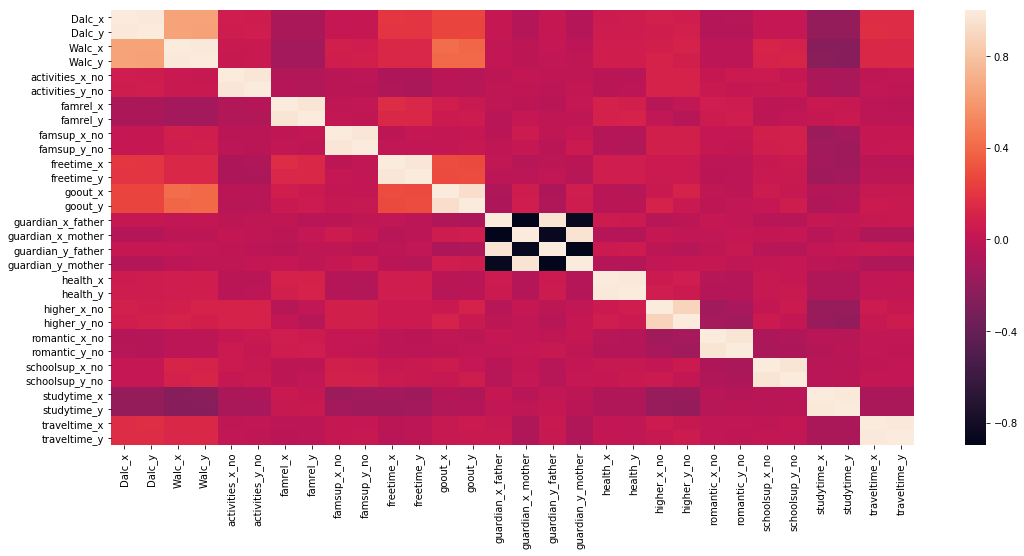

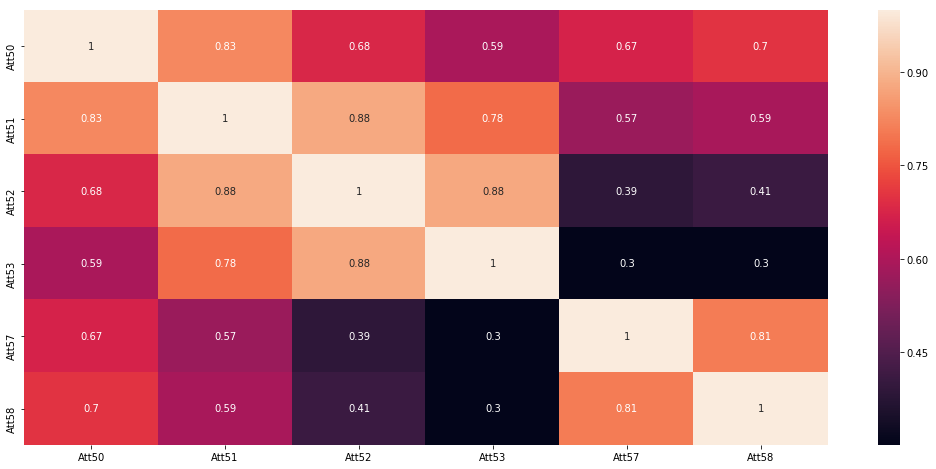

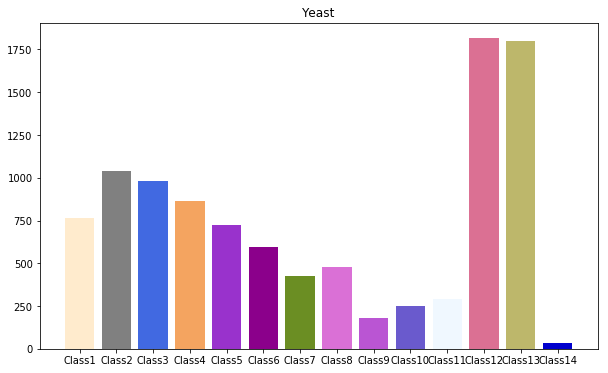

In [88]:
ShowCountOnlyForTargetLabels(y_yeast,'Yeast')

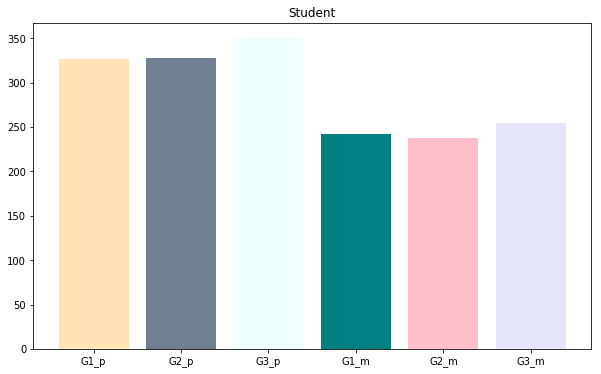

In [89]:
ShowCountOnlyForTargetLabels(y_student,'Student')

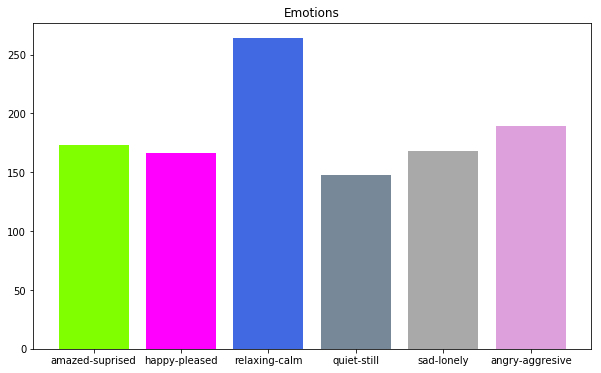

In [90]:
ShowCountOnlyForTargetLabels(y_emotions,'Emotions')

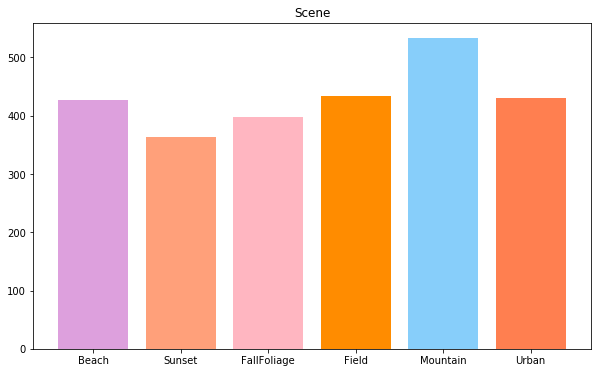

In [91]:
ShowCountOnlyForTargetLabels(y_scene,'Scene')

# Modeling and Evaluation

# 1. Problem transformation methods

##     a)The binary relevance method (BR)
the simplest problem transformation method
BR learns a binary classifier for each label

--- labels are predicted independently of each other and label dependencies are not taken into account.

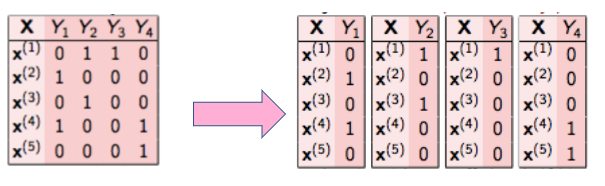

In [92]:
Image(filename="C:\\Users\\Dusica\\Desktop\\RESURSII ZA MLC\\BinaryRelevance2.png",width=500, height=300)

In [93]:
#method for creating table with measures
def  showMeMeasuresDF(b_test,predictions,train_time,predict_time,method):
    df=pd.DataFrame()
    df['Measures']=(['Accuracy','Macro-Precision','Micro-Precision','Macro-Recall','Micro-Recall','Macro-F1','Micro-F1','0/1 loss','Hamming loss','Roc auc score','Train time','Test time','AMI'])
                    
    df[method]=([round(accuracy_score(b_test,predictions),4),round(precision_score(b_test,predictions,average='micro'),4)\
    ,round(precision_score(b_test,predictions,average='macro'),4)\
    ,round(recall_score(b_test,predictions,average='macro'),4)\
    ,round(recall_score(b_test,predictions,average='micro'),4)\
    ,round(f1_score(b_test,predictions,average='macro'),4)\
    ,round(f1_score(b_test,predictions,average='micro'),4)\
    ,round(zero_one_loss(b_test,predictions),4)\
    ,round(hamming_loss(b_test,predictions),4),\
    round(roc_auc_score(b_test,predictions,average='macro'),4),train_time,predict_time])
    
    print(df)

In [94]:
#Predict model-methods for Binary relevance(br), Classifier chains(cc), Label powerset(lp)
def predictModel(a_train, a_test, b_train, b_test,signal):
    if signal=='br':
        classifier = BinaryRelevance(svm.SVC(probability=False))
    if signal=='cc':
        classifier = ClassifierChain(svm.SVC(probability=False))

    if signal=='lp':
        classifier = LabelPowerset(svm.SVC(probability=False))
    t0=time.time()
    classifier.fit(a_train, b_train)
    train_time=round(time.time()-t0,3)
    t1=time.time()
    predictions = classifier.predict(a_test)
    predict_time=round(time.time()-t1, 3)
 
    showMeMeasuresPrettyTable(b_test,predictions.toarray(),train_time,predict_time)
    return predictions,train_time,predict_time

In [95]:
#method for creating table with measures
def  showMeMeasuresPrettyTable(y_test,predictions,train_time,predict_time):
    t = PrettyTable(['Measures', 'Value'])
    t.add_row(['Accuracy',round(accuracy_score(y_test,predictions),4)])
    t.add_row(['Macro-Precision',round(precision_score(y_test,predictions,average='macro'),4)])
    t.add_row(['Micro-Precision',round(precision_score(y_test,predictions,average='micro'),4)])
    t.add_row(['Macro-Recall',round(recall_score(y_test,predictions,average='macro'),4)])
    t.add_row(['Micro-Recall',round(recall_score(y_test,predictions,average='micro'),4)])
    t.add_row(['Macro-F1',round(f1_score(y_test,predictions,average='macro'),4)])
    t.add_row(['Micro-F1',round(f1_score(y_test,predictions,average='micro'),4)])
    t.add_row(['0/1 loss',round(zero_one_loss(y_test,predictions),4)])
    t.add_row(['Hamming loss',round(hamming_loss(y_test,predictions),4)])
    t.add_row(['Roc auc score',round(roc_auc_score(y_test,predictions, average='macro'),4)])
    t.add_row(['Train time',train_time])
    t.add_row(['Test time',predict_time])
    print (t)

## Student performance dataset
#### TARGET LABELS [G1_p, G2_p, G3_p, G1_m, G2_m, G3_m]

In [96]:
predictions_student,train_time_student,predict_time_student=predictModel(x_student_train, x_student_test, y_student_train, y_student_test,'br')

+-----------------+--------+
|     Measures    | Value  |
+-----------------+--------+
|     Accuracy    | 0.487  |
| Macro-Precision | 0.7793 |
| Micro-Precision | 0.7843 |
|   Macro-Recall  | 0.9716 |
|   Micro-Recall  | 0.9751 |
|     Macro-F1    | 0.8633 |
|     Micro-F1    | 0.8693 |
|     0/1 loss    | 0.513  |
|   Hamming loss  | 0.2217 |
|  Roc auc score  | 0.5436 |
|    Train time   | 0.079  |
|    Test time    | 0.021  |
+-----------------+--------+


In [97]:
predictions_student.todense()[0:5]

matrix([[1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]], dtype=int32)

## Yeast dataset
#### TARGET LABELS [Class1:Class14] 

In [98]:
predictions_yeast,train_time_yeast,predict_time_yeast = predictModel(x_yeast_train, x_yeast_test, y_yeast_train, y_yeast_test,'br')

+-----------------+--------+
|     Measures    | Value  |
+-----------------+--------+
|     Accuracy    | 0.011  |
| Macro-Precision | 0.2427 |
| Micro-Precision | 0.7555 |
|   Macro-Recall  | 0.1456 |
|   Micro-Recall  | 0.356  |
|     Macro-F1    | 0.1282 |
|     Micro-F1    | 0.4839 |
|     0/1 loss    | 0.989  |
|   Hamming loss  | 0.2321 |
|  Roc auc score  | 0.5013 |
|    Train time   | 4.949  |
|    Test time    | 2.013  |
+-----------------+--------+


In [99]:
predictions_yeast.todense()

matrix([[0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0],
        ...,
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0]], dtype=int64)

In [100]:
predictions_yeast.todense().shape

(726, 14)

In [101]:
#probas_yeast.todense()[1,:]

## Emotions dataset
#### TARGET LABELS ["amazed-suprised":"angry-aggresive"] 

In [102]:
predictions_emotions,train_time_emotions,predict_time_emotions = predictModel(x_emotions_train, x_emotions_test, y_emotions_train, y_emotions_test,'br')

+-----------------+--------+
|     Measures    | Value  |
+-----------------+--------+
|     Accuracy    | 0.1573 |
| Macro-Precision | 0.6109 |
| Micro-Precision | 0.6779 |
|   Macro-Recall  | 0.3984 |
|   Micro-Recall  | 0.4234 |
|     Macro-F1    | 0.4604 |
|     Micro-F1    | 0.5213 |
|     0/1 loss    | 0.8427 |
|   Hamming loss  | 0.2425 |
|  Roc auc score  | 0.6518 |
|    Train time   | 0.449  |
|    Test time    | 0.103  |
+-----------------+--------+


In [103]:
predictions_emotions.todense()

matrix([[0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1]], dtype=int64)

In [104]:
predictions_emotions.todense().shape

(178, 6)

## Scene dataset
#### TARGET LABELS ["Beach":"Urban"] 

In [105]:
predictions_scene,train_time_scene,predict_time_scene= predictModel(x_scene_train, x_scene_test, y_scene_train, y_scene_test,'br')

+-----------------+--------+
|     Measures    | Value  |
+-----------------+--------+
|     Accuracy    | 0.2697 |
| Macro-Precision | 0.6452 |
| Micro-Precision | 0.9554 |
|   Macro-Recall  | 0.2858 |
|   Micro-Recall  | 0.2765 |
|     Macro-F1    | 0.3616 |
|     Micro-F1    | 0.4289 |
|     0/1 loss    | 0.7303 |
|   Hamming loss  | 0.1314 |
|  Roc auc score  | 0.6415 |
|    Train time   | 4.224  |
|    Test time    | 1.316  |
+-----------------+--------+


In [106]:
predictions_scene.todense()

matrix([[0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]], dtype=int64)

In [107]:
predictions_scene.todense().shape

(723, 6)

## b) Classifier Chains
 -The first classifier is trained just on the input data and then each next classifier is trained on the input space and all the previous classifiers in the chain.

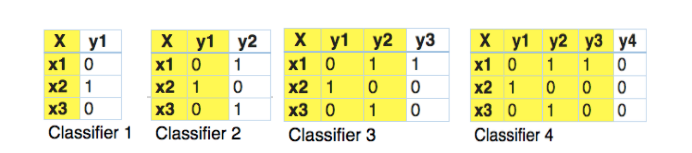

In [108]:
Image(filename="C:\\Users\\Dusica\\Desktop\\RESURSII ZA MLC\\ClassifierChains.png",width=700, height=700)

## Student performance dataset
#### TARGET LABELS [G1_p, G2_p, G3_p, G1_m, G2_m, G3_m]

In [109]:
predictions_student_cc,train_time_student_cc,predict_time_student_cc = predictModel(x_student_train, x_student_test, y_student_train, y_student_test,'cc')

+-----------------+--------+
|     Measures    | Value  |
+-----------------+--------+
|     Accuracy    | 0.4957 |
| Macro-Precision | 0.7817 |
| Micro-Precision | 0.7867 |
|   Macro-Recall  | 0.9716 |
|   Micro-Recall  | 0.9751 |
|     Macro-F1    | 0.8648 |
|     Micro-F1    | 0.8708 |
|     0/1 loss    | 0.5043 |
|   Hamming loss  | 0.2188 |
|  Roc auc score  | 0.5483 |
|    Train time   | 0.057  |
|    Test time    |  0.03  |
+-----------------+--------+


## Yeast dataset
#### TARGET LABELS [Class1:Class14] 

In [110]:
predictions_yeast_cc,train_time_yeast_cc,predict_time_yeast_cc = predictModel(x_yeast_train, x_yeast_test, y_yeast_train, y_yeast_test,'cc')

+-----------------+--------+
|     Measures    | Value  |
+-----------------+--------+
|     Accuracy    | 0.0138 |
| Macro-Precision | 0.1801 |
| Micro-Precision | 0.7304 |
|   Macro-Recall  | 0.1688 |
|   Micro-Recall  | 0.3775 |
|     Macro-F1    | 0.1609 |
|     Micro-F1    | 0.4978 |
|     0/1 loss    | 0.9862 |
|   Hamming loss  | 0.2329 |
|  Roc auc score  | 0.5079 |
|    Train time   | 4.543  |
|    Test time    | 1.537  |
+-----------------+--------+


## Emotions dataset

In [111]:
predictions_emotions_cc,train_time_emotions_cc,predict_time_emotions_cc = predictModel(x_emotions_train, x_emotions_test, y_emotions_train, y_emotions_test,'cc')

+-----------------+--------+
|     Measures    | Value  |
+-----------------+--------+
|     Accuracy    | 0.1573 |
| Macro-Precision | 0.6115 |
| Micro-Precision | 0.6777 |
|   Macro-Recall  | 0.4045 |
|   Micro-Recall  | 0.4294 |
|     Macro-F1    | 0.4658 |
|     Micro-F1    | 0.5257 |
|     0/1 loss    | 0.8427 |
|   Hamming loss  | 0.2416 |
|  Roc auc score  | 0.6541 |
|    Train time   | 0.217  |
|    Test time    | 0.102  |
+-----------------+--------+


## Scene dataset

In [112]:
predictions_scene5_cc,train_time_scene5_cc,predict_time_scene5_cc = predictModel(x_scene_train, x_scene_test, y_scene_train, y_scene_test,'cc')

+-----------------+--------+
|     Measures    | Value  |
+-----------------+--------+
|     Accuracy    | 0.3347 |
| Macro-Precision | 0.7745 |
| Micro-Precision | 0.9291 |
|   Macro-Recall  | 0.3514 |
|   Micro-Recall  | 0.3385 |
|     Macro-F1    | 0.4418 |
|     Micro-F1    | 0.4962 |
|     0/1 loss    | 0.6653 |
|   Hamming loss  | 0.1226 |
|  Roc auc score  | 0.6729 |
|    Train time   |  4.79  |
|    Test time    | 1.352  |
+-----------------+--------+


In [113]:
predictions_scene_cc,train_time_scene_cc,predict_time_scene_cc = predictModel(x_scene_train, x_scene_test, y_scene_train, y_scene_test,'cc')

+-----------------+--------+
|     Measures    | Value  |
+-----------------+--------+
|     Accuracy    | 0.3347 |
| Macro-Precision | 0.7745 |
| Micro-Precision | 0.9291 |
|   Macro-Recall  | 0.3514 |
|   Micro-Recall  | 0.3385 |
|     Macro-F1    | 0.4418 |
|     Micro-F1    | 0.4962 |
|     0/1 loss    | 0.6653 |
|   Hamming loss  | 0.1226 |
|  Roc auc score  | 0.6729 |
|    Train time   | 3.617  |
|    Test time    | 1.348  |
+-----------------+--------+


In [114]:
predictions_scene_cc,train_time_scene_cc,predict_time_scene_cc = predictModel(x_scene_train, x_scene_test, y_scene_train, y_scene_test,'cc')

+-----------------+--------+
|     Measures    | Value  |
+-----------------+--------+
|     Accuracy    | 0.3347 |
| Macro-Precision | 0.7745 |
| Micro-Precision | 0.9291 |
|   Macro-Recall  | 0.3514 |
|   Micro-Recall  | 0.3385 |
|     Macro-F1    | 0.4418 |
|     Micro-F1    | 0.4962 |
|     0/1 loss    | 0.6653 |
|   Hamming loss  | 0.1226 |
|  Roc auc score  | 0.6729 |
|    Train time   | 3.636  |
|    Test time    | 1.474  |
+-----------------+--------+


In [115]:
predictions_scene_cc,train_time_scene_cc,predict_time_scene_cc = predictModel(x_scene_train, x_scene_test, y_scene_train, y_scene_test,'cc')

+-----------------+--------+
|     Measures    | Value  |
+-----------------+--------+
|     Accuracy    | 0.3347 |
| Macro-Precision | 0.7745 |
| Micro-Precision | 0.9291 |
|   Macro-Recall  | 0.3514 |
|   Micro-Recall  | 0.3385 |
|     Macro-F1    | 0.4418 |
|     Micro-F1    | 0.4962 |
|     0/1 loss    | 0.6653 |
|   Hamming loss  | 0.1226 |
|  Roc auc score  | 0.6729 |
|    Train time   | 4.777  |
|    Test time    | 1.344  |
+-----------------+--------+


## c) Label Powerset
It transforms the problem into a multi-class problem with one multi-class classifier which is trained on all unique label combinations found in the training data.
x1 and x4 have the same labels, similarly, x3 and x6 have the same set of labels. Label powerset transforms this problem into a single multi-class problem as shown below.
Disadvantage:  The only disadvantage of this is that as the training data increases, number of classes also inreases, and measure values decrease.  

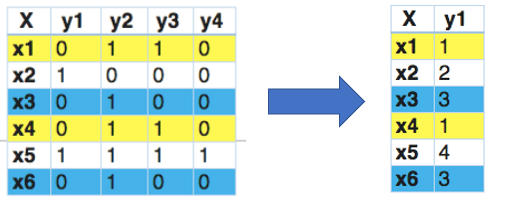

In [116]:
Image(filename="C:\\Users\\Dusica\\Desktop\\RESURSII ZA MLC\\LabelPowerset2.png",width=500, height=300)

## Student performance dataset
#### TARGET LABELS [G1_p, G2_p, G3_p, G1_m, G2_m, G3_m]

In [117]:
predictions_student_lp,train_time_student_lp,predict_time_students_lp = predictModel(x_student_train, x_student_test, y_student_train, y_student_test,'lp')

+-----------------+--------+
|     Measures    | Value  |
+-----------------+--------+
|     Accuracy    | 0.4957 |
| Macro-Precision | 0.7638 |
| Micro-Precision | 0.7655 |
|   Macro-Recall  | 0.9935 |
|   Micro-Recall  | 0.9943 |
|     Macro-F1    | 0.8602 |
|     Micro-F1    | 0.865  |
|     0/1 loss    | 0.5043 |
|   Hamming loss  | 0.2348 |
|  Roc auc score  | 0.5153 |
|    Train time   | 0.045  |
|    Test time    | 0.021  |
+-----------------+--------+


## Yeast dataset
#### TARGET LABELS [Class1:Class14] 

In [118]:
predictions_yeast_lp,train_time_yeast_lp,predict_time_yeast_lp = predictModel(x_yeast_train, x_yeast_test, y_yeast_train, y_yeast_test,'lp')

+-----------------+--------+
|     Measures    | Value  |
+-----------------+--------+
|     Accuracy    | 0.1336 |
| Macro-Precision | 0.2221 |
| Micro-Precision | 0.5809 |
|   Macro-Recall  | 0.298  |
|   Micro-Recall  | 0.543  |
|     Macro-F1    | 0.2256 |
|     Micro-F1    | 0.5613 |
|     0/1 loss    | 0.8664 |
|   Hamming loss  | 0.2594 |
|  Roc auc score  | 0.5093 |
|    Train time   | 1.759  |
|    Test time    | 0.919  |
+-----------------+--------+


## Emotions dataset

In [119]:
predictions_emotions_lp,train_time_emotions_lp,predict_time_emotions_lp = predictModel(x_emotions_train,x_emotions_test, y_emotions_train,y_emotions_test,'lp')

+-----------------+--------+
|     Measures    | Value  |
+-----------------+--------+
|     Accuracy    | 0.309  |
| Macro-Precision | 0.554  |
| Micro-Precision | 0.5812 |
|   Macro-Recall  | 0.5863 |
|   Micro-Recall  | 0.6126 |
|     Macro-F1    | 0.5673 |
|     Micro-F1    | 0.5965 |
|     0/1 loss    | 0.691  |
|   Hamming loss  | 0.2584 |
|  Roc auc score  | 0.6915 |
|    Train time   | 0.112  |
|    Test time    | 0.049  |
+-----------------+--------+


## Scene dataset

In [120]:
predictions_scene_lp,train_time_scene_lp,predict_time_scene_lp = predictModel(x_scene_train,x_scene_test, y_scene_train,y_scene_test,'lp')

+-----------------+--------+
|     Measures    | Value  |
+-----------------+--------+
|     Accuracy    | 0.7054 |
| Macro-Precision | 0.7732 |
| Micro-Precision | 0.7649 |
|   Macro-Recall  | 0.7188 |
|   Micro-Recall  | 0.7145 |
|     Macro-F1    | 0.7434 |
|     Micro-F1    | 0.7388 |
|     0/1 loss    | 0.2946 |
|   Hamming loss  | 0.0901 |
|  Roc auc score  | 0.8354 |
|    Train time   | 1.765  |
|    Test time    | 0.676  |
+-----------------+--------+


# 2. Algorithm adaptation methods

Adapted algorithm, as the name suggests, adapting the algorithm to directly perform multi-label classification, rather than transforming the problem into different subsets of problems.

multi-label version of kNN is represented by MLkNN

In [121]:
# MLkNN
#Predict model-methods for MLkNN and Binary Relevance multi-label classifier based on k Nearest Neighbours method.
def predictModelAdapt(a_train, a_test, b_train,b_test,signal,k):
        if signal=='mlknn':
            classifier = MLkNN(k=k)
        if signal=='brknn':
            classifier = BRkNNaClassifier(k=k)
        t0=time.time()
        classifier.fit(csr_matrix(a_train.values), csr_matrix(b_train.values))
        train_time=round(time.time()-t0, 3)
        t1=time.time()
        predictions = classifier.predict(csr_matrix(a_test.values))
        predict_time=round(time.time()-t1, 3)
        showMeMeasuresPrettyTable(b_test,predictions.toarray(),train_time,predict_time)
        return predictions,train_time,predict_time

### STUDENT PERFORMANCE

In [122]:
predictions_student_MLkNN,train_time_student_mlknn,predict_time_student_mlknn=predictModelAdapt(x_student_train, x_student_test, y_student_train, y_student_test,'mlknn',20)

+-----------------+--------+
|     Measures    | Value  |
+-----------------+--------+
|     Accuracy    | 0.4435 |
| Macro-Precision | 0.7725 |
| Micro-Precision | 0.7766 |
|   Macro-Recall  | 0.9752 |
|   Micro-Recall  | 0.9789 |
|     Macro-F1    | 0.8599 |
|     Micro-F1    | 0.8661 |
|     0/1 loss    | 0.5565 |
|   Hamming loss  | 0.229  |
|  Roc auc score  | 0.5408 |
|    Train time   | 0.585  |
|    Test time    | 0.114  |
+-----------------+--------+


In [123]:
predictions_student_BRkNN=predictModelAdapt(x_student_train, x_student_test, y_student_train, y_student_test,'brknn',8)

+-----------------+--------+
|     Measures    | Value  |
+-----------------+--------+
|     Accuracy    | 0.4696 |
| Macro-Precision | 0.7689 |
| Micro-Precision | 0.7721 |
|   Macro-Recall  | 0.9845 |
|   Micro-Recall  | 0.9866 |
|     Macro-F1    | 0.8608 |
|     Micro-F1    | 0.8663 |
|     0/1 loss    | 0.5304 |
|   Hamming loss  | 0.2304 |
|  Roc auc score  | 0.5254 |
|    Train time   | 0.002  |
|    Test time    | 0.092  |
+-----------------+--------+


### YEAST

In [124]:
predictions_yeast_MLkNN,train_time_yeast_mlknn,predict_time_yeast_mlknn=predictModelAdapt(x_yeast_train, x_yeast_test, y_yeast_train,y_yeast_test,'mlknn',20)   

+-----------------+--------+
|     Measures    | Value  |
+-----------------+--------+
|     Accuracy    | 0.1763 |
| Macro-Precision | 0.5601 |
| Micro-Precision | 0.7165 |
|   Macro-Recall  | 0.3672 |
|   Micro-Recall  | 0.5906 |
|     Macro-F1    | 0.3971 |
|     Micro-F1    | 0.6475 |
|     0/1 loss    | 0.8237 |
|   Hamming loss  | 0.1966 |
|  Roc auc score  | 0.5886 |
|    Train time   | 6.936  |
|    Test time    | 2.698  |
+-----------------+--------+


In [125]:
predictions_yeast_BRkNN=predictModelAdapt(x_yeast_train, x_yeast_test, y_yeast_train,y_yeast_test,'brknn',13)

+-----------------+--------+
|     Measures    | Value  |
+-----------------+--------+
|     Accuracy    | 0.1625 |
| Macro-Precision | 0.6023 |
| Micro-Precision | 0.7619 |
|   Macro-Recall  | 0.2998 |
|   Micro-Recall  | 0.515  |
|     Macro-F1    | 0.3485 |
|     Micro-F1    | 0.6146 |
|     0/1 loss    | 0.8375 |
|   Hamming loss  | 0.1975 |
|  Roc auc score  | 0.5755 |
|    Train time   | 0.055  |
|    Test time    | 1.555  |
+-----------------+--------+


### Emotions

In [126]:
predictions_emotions_MLkNN,train_time_emotions_mlknn,predict_time_emotions_mlknn=predictModelAdapt(x_emotions_train, x_emotions_test, y_emotions_train,y_emotions_test,'mlknn',20)

+-----------------+--------+
|     Measures    | Value  |
+-----------------+--------+
|     Accuracy    | 0.1348 |
| Macro-Precision | 0.5766 |
| Micro-Precision | 0.6388 |
|   Macro-Recall  | 0.4032 |
|   Micro-Recall  | 0.4354 |
|     Macro-F1    | 0.4547 |
|     Micro-F1    | 0.5179 |
|     0/1 loss    | 0.8652 |
|   Hamming loss  | 0.2528 |
|  Roc auc score  | 0.6437 |
|    Train time   |  0.68  |
|    Test time    | 0.255  |
+-----------------+--------+


In [127]:
predictions_emotions_BRkNN=predictModelAdapt(x_emotions_train, x_emotions_test, y_emotions_train,y_emotions_test,'brknn',8)

+-----------------+--------+
|     Measures    | Value  |
+-----------------+--------+
|     Accuracy    | 0.191  |
| Macro-Precision | 0.5412 |
| Micro-Precision | 0.5836 |
|   Macro-Recall  | 0.5087 |
|   Micro-Recall  | 0.5345 |
|     Macro-F1    | 0.5134 |
|     Micro-F1    | 0.558  |
|     0/1 loss    | 0.809  |
|   Hamming loss  | 0.264  |
|  Roc auc score  | 0.6646 |
|    Train time   | 0.004  |
|    Test time    | 0.214  |
+-----------------+--------+


### Scene

In [128]:
predictions_scene_MLkNN,train_time_scene_mlknn,predict_time_scene_mlknn=predictModelAdapt(x_scene_train, x_scene_test, y_scene_train,y_scene_test,'mlknn',20)

+-----------------+--------+
|     Measures    | Value  |
+-----------------+--------+
|     Accuracy    | 0.6335 |
| Macro-Precision | 0.769  |
| Micro-Precision | 0.7706 |
|   Macro-Recall  | 0.6965 |
|   Micro-Recall  | 0.6899 |
|     Macro-F1    | 0.7282 |
|     Micro-F1    | 0.728  |
|     0/1 loss    | 0.3665 |
|   Hamming loss  | 0.092  |
|  Roc auc score  | 0.8258 |
|    Train time   | 5.735  |
|    Test time    | 3.196  |
+-----------------+--------+


In [129]:
predictions_scene_BRkNN=predictModelAdapt(x_scene_train, x_scene_test, y_scene_train,y_scene_test,'brknn',8)

+-----------------+--------+
|     Measures    | Value  |
+-----------------+--------+
|     Accuracy    | 0.6445 |
| Macro-Precision | 0.7892 |
| Micro-Precision | 0.7563 |
|   Macro-Recall  | 0.7021 |
|   Micro-Recall  | 0.6938 |
|     Macro-F1    | 0.7303 |
|     Micro-F1    | 0.7237 |
|     0/1 loss    | 0.3555 |
|   Hamming loss  | 0.0945 |
|  Roc auc score  | 0.8268 |
|    Train time   | 0.138  |
|    Test time    | 2.952  |
+-----------------+--------+


# 3. Ensemble Approaches
Ensemble always produces better results. Scikit-Multilearn library provides different ensembling classification functions, which you can use for obtaining better results.

In [130]:
# RakelD
def predictModelEnsemble(a_train, a_test, b_train,b_test,signal,k):
        if signal=='rakeld':
            classifier = RakelD(LabelPowerset(RandomForestClassifier()), k)
                        #classifier = RakelD(LabelPowerset(svm.SVC(probability=True)), k)
        t0=time.time()
        classifier.fit(a_train, b_train)
        train_time=round(time.time()-t0,3)
        t1=time.time()
        predictions = classifier.predict(csr_matrix(a_test.values))
        predict_time=round(time.time()-t1,3)
        showMeMeasuresPrettyTable(b_test,predictions.toarray(),train_time,predict_time)
        return predictions,train_time,predict_time

### Student

In [131]:
predictions_student_rakeld,train_time_student_rakel,predict_time_student_rakel=predictModelEnsemble(x_student_train, x_student_test, y_student_train, y_student_test,'rakeld',6)

+-----------------+--------+
|     Measures    | Value  |
+-----------------+--------+
|     Accuracy    | 0.487  |
| Macro-Precision | 0.8018 |
| Micro-Precision | 0.8081 |
|   Macro-Recall  | 0.9547 |
|   Micro-Recall  | 0.9598 |
|     Macro-F1    | 0.8703 |
|     Micro-F1    | 0.8774 |
|     0/1 loss    | 0.513  |
|   Hamming loss  | 0.2029 |
|  Roc auc score  | 0.6141 |
|    Train time   | 0.033  |
|    Test time    | 0.023  |
+-----------------+--------+


### Yeast

In [132]:
predictions_yeast_rakeld,train_time_yeast_rakel,predict_time_yeast_rakel=predictModelEnsemble(x_yeast_train,x_yeast_test,y_yeast_train,y_yeast_test,'rakeld',14)

+-----------------+--------+
|     Measures    | Value  |
+-----------------+--------+
|     Accuracy    | 0.1983 |
| Macro-Precision | 0.417  |
| Micro-Precision |  0.62  |
|   Macro-Recall  | 0.3668 |
|   Micro-Recall  | 0.5681 |
|     Macro-F1    | 0.3768 |
|     Micro-F1    | 0.5929 |
|     0/1 loss    | 0.8017 |
|   Hamming loss  | 0.2385 |
|  Roc auc score  | 0.5673 |
|    Train time   | 1.243  |
|    Test time    | 0.149  |
+-----------------+--------+


### Emotions

In [133]:
predictions_emotions_rakeld,train_time_emotions_rakel,predict_time_emotions_rakel=predictModelEnsemble(x_emotions_train,x_emotions_test,y_emotions_train,y_emotions_test,'rakeld',6)

+-----------------+--------+
|     Measures    | Value  |
+-----------------+--------+
|     Accuracy    | 0.3371 |
| Macro-Precision | 0.6234 |
| Micro-Precision | 0.6486 |
|   Macro-Recall  | 0.6693 |
|   Micro-Recall  | 0.6817 |
|     Macro-F1    | 0.6416 |
|     Micro-F1    | 0.6647 |
|     0/1 loss    | 0.6629 |
|   Hamming loss  | 0.2144 |
|  Roc auc score  | 0.749  |
|    Train time   | 0.076  |
|    Test time    | 0.028  |
+-----------------+--------+


### Scene

In [134]:
predictions_scene_rakeld,train_time_scene_rakel,predict_time_scene_rakel=predictModelEnsemble(x_scene_train,x_scene_test,y_scene_train,y_scene_test,'rakeld',6)

+-----------------+--------+
|     Measures    | Value  |
+-----------------+--------+
|     Accuracy    | 0.6846 |
| Macro-Precision | 0.7404 |
| Micro-Precision | 0.7373 |
|   Macro-Recall  | 0.7065 |
|   Micro-Recall  | 0.6964 |
|     Macro-F1    | 0.7176 |
|     Micro-F1    | 0.7163 |
|     0/1 loss    | 0.3154 |
|   Hamming loss  | 0.0984 |
|  Roc auc score  | 0.8262 |
|    Train time   | 0.469  |
|    Test time    | 0.107  |
+-----------------+--------+


# RESULTS

#### Shorter way -- through a method and for loop

In [135]:
all_a_train=[x_student_train,x_yeast_train,x_emotions_train,x_scene_train]
all_b_train=[y_student_train,y_yeast_train,y_emotions_train,y_scene_train]
all_a_test=[x_student_test,x_yeast_test,x_emotions_test,x_scene_test]
all_b_test=[y_student_test,y_yeast_test,y_emotions_test,y_scene_test]

In [136]:
def highlight_min(s):
    '''
    highlight the minimum in a Series yellow.
    '''
    is_min= s == s.min()
    return ['background-color: red' if v else '' for v in is_min]

In [137]:
writer = pd.ExcelWriter('results_master_proba_mlc.xlsx')

In [138]:
def getMeasuresTablesFinalResults2(classifiers,b_test,predictions,train_time,pred_time,df_name):
    df=pd.DataFrame()
    t = PrettyTable(['Measures'])
    df['Measures']=['Accuracy','Macro-Precision','Micro-Precision','Macro-Recall','Micro-Recall','Macro-F1','Micro-F1','0/1 loss','Hamming loss','Roc auc score','Train time','Test time']

    for i in range(len(classifiers)):
        
        df[classifiers[i].__class__.__name__]=([round(accuracy_score(b_test,predictions[i]),4),round(precision_score(b_test,predictions[i],average='micro'),4)\
        ,round(precision_score(b_test,predictions[i],average='macro'),4)\
        ,round(recall_score(b_test,predictions[i],average='macro'),4)\
        ,round(recall_score(b_test,predictions[i],average='micro'),4)\
        ,round(f1_score(b_test,predictions[i],average='macro'),4)\
        ,round(f1_score(b_test,predictions[i],average='micro'),4)\
        ,round(zero_one_loss(b_test,predictions[i]),4)\
        ,round(hamming_loss(b_test,predictions[i]),4)\
        ,round(roc_auc_score(b_test,predictions[i].todense(),average='macro'),4)\
        ,train_time[i],pred_time[i]])
        
    df=df.set_index(['Measures'])
    df=df.style.apply(highlight_max,axis=1)
    df.to_excel(writer,df_name)
   


    return df

In [139]:
#classifiers=[BinaryRelevance(LogisticRegression()),ClassifierChain(LogisticRegression()),LabelPowerset(LogisticRegression()),MLkNN(k=20),RakelD(LabelPowerset(RandomForestClassifier()), 14)]
classifiers=[BinaryRelevance(svm.SVC()),ClassifierChain(svm.SVC()),LabelPowerset(svm.SVC()),MLkNN(k=20),RakelD(LabelPowerset(svm.SVC()), 14)]

predictions_stud=[predictions_student,predictions_student_cc,predictions_student_lp,predictions_student_MLkNN,predictions_student_rakeld]
predictions_yeast_all=[predictions_yeast,predictions_yeast_cc,predictions_yeast_lp,predictions_yeast_MLkNN,predictions_yeast_rakeld]
predictions_emo=[predictions_emotions,predictions_emotions_cc,predictions_emotions_lp,predictions_emotions_MLkNN,predictions_emotions_rakeld]
predictions_scene_all=[predictions_scene,predictions_scene_cc,predictions_scene_lp,predictions_scene_MLkNN,predictions_scene_rakeld]

time_stu=[predict_time_student,predict_time_student_cc,predict_time_students_lp,predict_time_student_mlknn,predict_time_student_rakel]
time_ye=[predict_time_yeast,predict_time_yeast_cc,predict_time_yeast_lp,predict_time_yeast_mlknn,predict_time_yeast_rakel]
time_emo=[predict_time_emotions,predict_time_emotions_cc,predict_time_emotions_lp,predict_time_emotions_mlknn,predict_time_emotions_rakel]
time_scene=[predict_time_scene,predict_time_scene_cc,predict_time_scene_lp,predict_time_scene_mlknn,predict_time_scene_rakel]

t_time_stu=[train_time_student,train_time_student_cc,train_time_student_lp,train_time_student_mlknn,train_time_student_rakel]
t_time_ye=[train_time_yeast,train_time_yeast_cc,train_time_yeast_lp,train_time_yeast_mlknn,train_time_yeast_rakel]
t_time_emo=[train_time_emotions,train_time_emotions_cc,train_time_emotions_lp,train_time_emotions_mlknn,train_time_emotions_rakel]
t_time_scene=[train_time_scene,train_time_scene_cc,train_time_scene_lp,train_time_scene_mlknn,train_time_scene_rakel]



In [140]:
print('Student performance\n')                   
getMeasuresTablesFinalResults2(classifiers,y_student_test,predictions_stud,t_time_stu,time_stu,'Student')

Student performance



,BinaryRelevance,ClassifierChain,LabelPowerset,MLkNN,RakelD
Measures,,,,,
Accuracy,0.487,0.4957,0.4957,0.4435,0.487
Macro-Precision,0.7843,0.7867,0.7655,0.7766,0.8081
Micro-Precision,0.7793,0.7817,0.7638,0.7725,0.8018
Macro-Recall,0.9716,0.9716,0.9935,0.9752,0.9547
Micro-Recall,0.9751,0.9751,0.9943,0.9789,0.9598
Macro-F1,0.8633,0.8648,0.8602,0.8599,0.8703
Micro-F1,0.8693,0.8708,0.865,0.8661,0.8774
0/1 loss,0.513,0.5043,0.5043,0.5565,0.513
Hamming loss,0.2217,0.2188,0.2348,0.229,0.2029


In [141]:
print('\nYeast\n')                   
getMeasuresTablesFinalResults2(classifiers,y_yeast_test,predictions_yeast_all,t_time_ye,time_ye,'Yeast')


Yeast



,BinaryRelevance,ClassifierChain,LabelPowerset,MLkNN,RakelD
Measures,,,,,
Accuracy,0.011,0.0138,0.1336,0.1763,0.1983
Macro-Precision,0.7555,0.7304,0.5809,0.7165,0.62
Micro-Precision,0.2427,0.1801,0.2221,0.5601,0.417
Macro-Recall,0.1456,0.1688,0.298,0.3672,0.3668
Micro-Recall,0.356,0.3775,0.543,0.5906,0.5681
Macro-F1,0.1282,0.1609,0.2256,0.3971,0.3768
Micro-F1,0.4839,0.4978,0.5613,0.6475,0.5929
0/1 loss,0.989,0.9862,0.8664,0.8237,0.8017
Hamming loss,0.2321,0.2329,0.2594,0.1966,0.2385


In [142]:
print('\nEmotions\n')                   
getMeasuresTablesFinalResults2(classifiers,y_emotions_test,predictions_emo,t_time_emo,time_emo,'Emotions')


Emotions



,BinaryRelevance,ClassifierChain,LabelPowerset,MLkNN,RakelD
Measures,,,,,
Accuracy,0.1573,0.1573,0.309,0.1348,0.3371
Macro-Precision,0.6779,0.6777,0.5812,0.6388,0.6486
Micro-Precision,0.6109,0.6115,0.554,0.5766,0.6234
Macro-Recall,0.3984,0.4045,0.5863,0.4032,0.6693
Micro-Recall,0.4234,0.4294,0.6126,0.4354,0.6817
Macro-F1,0.4604,0.4658,0.5673,0.4547,0.6416
Micro-F1,0.5213,0.5257,0.5965,0.5179,0.6647
0/1 loss,0.8427,0.8427,0.691,0.8652,0.6629
Hamming loss,0.2425,0.2416,0.2584,0.2528,0.2144


In [143]:
print('\nScene\n')                   
getMeasuresTablesFinalResults2(classifiers,y_scene_test,predictions_scene_all,t_time_scene,time_scene,'Scene')


Scene



,BinaryRelevance,ClassifierChain,LabelPowerset,MLkNN,RakelD
Measures,,,,,
Accuracy,0.2697,0.3347,0.7054,0.6335,0.6846
Macro-Precision,0.9554,0.9291,0.7649,0.7706,0.7373
Micro-Precision,0.6452,0.7745,0.7732,0.769,0.7404
Macro-Recall,0.2858,0.3514,0.7188,0.6965,0.7065
Micro-Recall,0.2765,0.3385,0.7145,0.6899,0.6964
Macro-F1,0.3616,0.4418,0.7434,0.7282,0.7176
Micro-F1,0.4289,0.4962,0.7388,0.728,0.7163
0/1 loss,0.7303,0.6653,0.2946,0.3665,0.3154
Hamming loss,0.1314,0.1226,0.0901,0.092,0.0984


In [144]:
#save DataFrame results as .xcl file with different sheets

In [145]:
writer.save()

## Comparison between ML methods

### Characteristics of the Datasets  

In [146]:
Listpredictions_br=[predictions_student,predictions_yeast,predictions_emotions,predictions_scene]
Listpredictions_cc=[predictions_student_cc,predictions_yeast_cc,predictions_emotions_cc,predictions_scene_cc]
Listpredictions_lp=[predictions_student_lp,predictions_yeast_lp,predictions_emotions_lp,predictions_scene_lp]
Listpredictions_mlknn=[predictions_student_MLkNN,predictions_yeast_MLkNN,predictions_emotions_MLkNN,predictions_scene_MLkNN]
Listpredictions_rakel=[predictions_student_rakeld,predictions_yeast_rakeld,predictions_emotions_rakeld,predictions_scene_rakeld]

In [147]:
def  getMeasuresTableForBinaryRelevance2(dataframes,dfnames,all_a_train,all_a_test,all_b_train,all_b_test,predictions):
    df=pd.DataFrame()
    t = PrettyTable(['Measures'])
    df['Measures']=['Accuracy','Macro-Precision','Micro-Precision','Macro-Recall','Micro-Recall','Macro-F1','Micro-F1','0/1 loss','Hamming loss','Roc auc score']
     

    #,roc_auc_score(b_test,predictionstodense(),average='macro')
    for i in range(len(dataframes)):

        a_train, a_test, b_train, b_test = all_a_train[i],all_a_test[i],all_b_train[i],all_b_test[i]
        
        df[dfnames[i]]=([round(accuracy_score(b_test,predictions[i]),4),round(precision_score(b_test,predictions[i],average='micro'),4)\
        ,round(precision_score(b_test,predictions[i],average='macro'),4)\
        ,round(recall_score(b_test,predictions[i],average='macro'),4)\
        ,round(recall_score(b_test,predictions[i],average='micro'),4)\
        ,round(f1_score(b_test,predictions[i],average='macro'),4)\
        ,round(f1_score(b_test,predictions[i],average='micro'),4)\
        ,round(zero_one_loss(b_test,predictions[i]),4)\
        ,round(hamming_loss(b_test,predictions[i]),4)\
        ,round(roc_auc_score(b_test,predictions[i].todense(),average='macro'),4)])
        
    df.set_index("Measures",inplace=True)

         
    return df.T


In [148]:
print('Binary relevance')
df1_br=getMeasuresTableForBinaryRelevance2(listDF,ListDFNames,all_a_train,all_a_test,all_b_train,all_b_test,Listpredictions_br)
df1_br.style.apply(highlight_max,axis=0)

Binary relevance


Measures,Accuracy,Macro-Precision,Micro-Precision,Macro-Recall,Micro-Recall,Macro-F1,Micro-F1,0/1 loss,Hamming loss,Roc auc score
Student,0.487,0.7843,0.7793,0.9716,0.9751,0.8633,0.8693,0.513,0.2217,0.5436
Yeast,0.011,0.7555,0.2427,0.1456,0.356,0.1282,0.4839,0.989,0.2321,0.5013
Emotions,0.1573,0.6779,0.6109,0.3984,0.4234,0.4604,0.5213,0.8427,0.2425,0.6518
Scene,0.2697,0.9554,0.6452,0.2858,0.2765,0.3616,0.4289,0.7303,0.1314,0.6415


In [149]:
print('Classifier chain')
df1_cc=getMeasuresTableForBinaryRelevance2(listDF,ListDFNames,all_a_train,all_a_test,all_b_train,all_b_test,Listpredictions_cc)
df1_cc.style.apply(highlight_max,axis=0)

Classifier chain


Measures,Accuracy,Macro-Precision,Micro-Precision,Macro-Recall,Micro-Recall,Macro-F1,Micro-F1,0/1 loss,Hamming loss,Roc auc score
Student,0.4957,0.7867,0.7817,0.9716,0.9751,0.8648,0.8708,0.5043,0.2188,0.5483
Yeast,0.0138,0.7304,0.1801,0.1688,0.3775,0.1609,0.4978,0.9862,0.2329,0.5079
Emotions,0.1573,0.6777,0.6115,0.4045,0.4294,0.4658,0.5257,0.8427,0.2416,0.6541
Scene,0.3347,0.9291,0.7745,0.3514,0.3385,0.4418,0.4962,0.6653,0.1226,0.6729


In [150]:
print('Label power-set')
df1_lp=getMeasuresTableForBinaryRelevance2(listDF,ListDFNames,all_a_train,all_a_test,all_b_train,all_b_test,Listpredictions_lp)
df1_lp.style.apply(highlight_max,axis=0)

Label power-set


Measures,Accuracy,Macro-Precision,Micro-Precision,Macro-Recall,Micro-Recall,Macro-F1,Micro-F1,0/1 loss,Hamming loss,Roc auc score
Student,0.4957,0.7655,0.7638,0.9935,0.9943,0.8602,0.865,0.5043,0.2348,0.5153
Yeast,0.1336,0.5809,0.2221,0.298,0.543,0.2256,0.5613,0.8664,0.2594,0.5093
Emotions,0.309,0.5812,0.554,0.5863,0.6126,0.5673,0.5965,0.691,0.2584,0.6915
Scene,0.7054,0.7649,0.7732,0.7188,0.7145,0.7434,0.7388,0.2946,0.0901,0.8354


In [151]:
print('Multi-label kNN')
df1_mlknn=getMeasuresTableForBinaryRelevance2(listDF,ListDFNames,all_a_train,all_a_test,all_b_train,all_b_test,Listpredictions_mlknn)
df1_mlknn.style.apply(highlight_max,axis=0)

Multi-label kNN


Measures,Accuracy,Macro-Precision,Micro-Precision,Macro-Recall,Micro-Recall,Macro-F1,Micro-F1,0/1 loss,Hamming loss,Roc auc score
Student,0.4435,0.7766,0.7725,0.9752,0.9789,0.8599,0.8661,0.5565,0.229,0.5408
Yeast,0.1763,0.7165,0.5601,0.3672,0.5906,0.3971,0.6475,0.8237,0.1966,0.5886
Emotions,0.1348,0.6388,0.5766,0.4032,0.4354,0.4547,0.5179,0.8652,0.2528,0.6437
Scene,0.6335,0.7706,0.769,0.6965,0.6899,0.7282,0.728,0.3665,0.092,0.8258


In [152]:
print('Random k-Label sets')
df1_rakel=getMeasuresTableForBinaryRelevance2(listDF,ListDFNames,all_a_train,all_a_test,all_b_train,all_b_test,Listpredictions_rakel)
df1_rakel.style.apply(highlight_max,axis=0)

Random k-Label sets


Measures,Accuracy,Macro-Precision,Micro-Precision,Macro-Recall,Micro-Recall,Macro-F1,Micro-F1,0/1 loss,Hamming loss,Roc auc score
Student,0.487,0.8081,0.8018,0.9547,0.9598,0.8703,0.8774,0.513,0.2029,0.6141
Yeast,0.1983,0.62,0.417,0.3668,0.5681,0.3768,0.5929,0.8017,0.2385,0.5673
Emotions,0.3371,0.6486,0.6234,0.6693,0.6817,0.6416,0.6647,0.6629,0.2144,0.749
Scene,0.6846,0.7373,0.7404,0.7065,0.6964,0.7176,0.7163,0.3154,0.0984,0.8262


In [153]:
res=pd.concat([df_char,df1_br,df1_cc,df1_lp,df1_mlknn,df1_rakel],axis=1)

In [154]:
writer = pd.ExcelWriter('results_master_proba_mlc2.xlsx')
res.to_excel(writer)
writer.save()

# EFFECT ON AUC

In [155]:
from sklearn.utils import shuffle

In [156]:
def makeDataSet(dataX,dataY,percentage):
    #name=pd.DataFrame()
    dataX=dataX.sample(frac=1,axis=1)
    dataX=dataX.iloc[:,0:round(dataX.shape[1]*(percentage/100))]
    x_train, x_test, y_train, y_test = train_test_split(dataX,dataY, test_size=0.3, random_state=42)
    print(dataX.shape,x_train.shape, x_test.shape, y_train.shape, y_test.shape,x_train.columns)
    return dataX,x_train, x_test, y_train, y_test

In [157]:
x_scene25,x_scene25_train, x_scene25_test, y_scene25_train, y_scene25_test=makeDataSet(x_scene,y_scene,25)

(2407, 74) (1684, 74) (723, 74) (1684, 6) (723, 6) Index(['Att186', 'Att50', 'Att250', 'Att65', 'Att137', 'Att82', 'Att61',
       'Att20', 'Att79', 'Att8', 'Att210', 'Att18', 'Att88', 'Att157', 'Att9',
       'Att291', 'Att46', 'Att161', 'Att242', 'Att247', 'Att207', 'Att67',
       'Att130', 'Att262', 'Att180', 'Att273', 'Att233', 'Att152', 'Att86',
       'Att153', 'Att199', 'Att154', 'Att277', 'Att212', 'Att48', 'Att117',
       'Att254', 'Att246', 'Att249', 'Att245', 'Att263', 'Att71', 'Att269',
       'Att206', 'Att239', 'Att256', 'Att23', 'Att127', 'Att148', 'Att25',
       'Att135', 'Att58', 'Att98', 'Att162', 'Att145', 'Att142', 'Att244',
       'Att3', 'Att286', 'Att52', 'Att118', 'Att10', 'Att280', 'Att158',
       'Att163', 'Att73', 'Att227', 'Att96', 'Att156', 'Att274', 'Att99',
       'Att40', 'Att213', 'Att214'],
      dtype='object')


In [158]:
x_scene50,x_scene50_train, x_scene50_test, y_scene50_train, y_scene50_test=makeDataSet(x_scene,y_scene,50)

(2407, 147) (1684, 147) (723, 147) (1684, 6) (723, 6) Index(['Att154', 'Att241', 'Att10', 'Att102', 'Att233', 'Att133', 'Att226',
       'Att293', 'Att103', 'Att13',
       ...
       'Att138', 'Att120', 'Att58', 'Att218', 'Att46', 'Att110', 'Att286',
       'Att128', 'Att126', 'Att253'],
      dtype='object', length=147)


In [159]:
x_scene75,x_scene75_train, x_scene75_test, y_scene75_train, y_scene75_test=makeDataSet(x_scene,y_scene,75)

(2407, 220) (1684, 220) (723, 220) (1684, 6) (723, 6) Index(['Att27', 'Att53', 'Att135', 'Att65', 'Att268', 'Att218', 'Att159',
       'Att37', 'Att91', 'Att227',
       ...
       'Att12', 'Att18', 'Att204', 'Att124', 'Att254', 'Att23', 'Att183',
       'Att168', 'Att95', 'Att108'],
      dtype='object', length=220)


x_student5,x_student_5_train, x_student_5_test, y_student_5_train, y_student_5_test=makeDataSet(x_student,y_student,5)

In [160]:
x_student25,x_student_25_train, x_student_25_test, y_student_25_train, y_student_25_test=makeDataSet(x_student,y_student,25)

(382, 14) (267, 14) (115, 14) (267, 6) (115, 6) Index(['Dalc_x', 'Walc_y', 'guardian_x_father', 'guardian_y_mother',
       'health_x', 'paid_x_no', 'famsup_y_no', 'freetime_x', 'activities_x_no',
       'failures_x', 'internet_no', 'Fjob_at_home', 'activities_y_no',
       'nursery_no'],
      dtype='object')


In [161]:
x_student50,x_student_50_train, x_student_50_test, y_student_50_train, y_student_50_test=makeDataSet(x_student,y_student,50)

(382, 28) (267, 28) (115, 28) (267, 6) (115, 6) Index(['absences_x', 'failures_y', 'Mjob_at_home', 'schoolsup_y_no', 'Dalc_x',
       'famsize_GT3', 'famrel_x', 'health_y', 'higher_y_no', 'school_GP',
       'Dalc_y', 'internet_no', 'romantic_y_no', 'freetime_x', 'address_R',
       'Mjob_services', 'traveltime_y', 'age', 'guardian_y_father', 'Walc_x',
       'activities_y_no', 'studytime_y', 'Mjob_health', 'Fjob_other',
       'paid_x_no', 'Medu', 'Fjob_health', 'romantic_x_no'],
      dtype='object')


In [162]:
x_student75,x_student_75_train, x_student_75_test, y_student_75_train, y_student_75_test=makeDataSet(x_student,y_student,75)

(382, 43) (267, 43) (115, 43) (267, 6) (115, 6) Index(['Fjob_services', 'guardian_y_father', 'Fjob_health', 'Fedu',
       'romantic_x_no', 'address_R', 'Mjob_other', 'higher_y_no', 'Pstatus_A',
       'absences_x', 'famrel_y', 'goout_x', 'absences_y', 'famsize_GT3',
       'Walc_y', 'health_y', 'romantic_y_no', 'Mjob_services', 'traveltime_y',
       'activities_y_no', 'school_GP', 'guardian_x_father', 'Fjob_at_home',
       'studytime_y', 'guardian_y_mother', 'Walc_x', 'famrel_x',
       'guardian_x_mother', 'famsup_x_no', 'Fjob_other', 'goout_y',
       'paid_y_no', 'schoolsup_x_no', 'failures_y', 'Medu', 'freetime_x',
       'studytime_x', 'schoolsup_y_no', 'traveltime_x', 'health_x',
       'failures_x', 'higher_x_no', 'Mjob_at_home'],
      dtype='object')


In [163]:
all_a_train=[x_student_25_train,x_student_50_train,x_student_75_train,x_student_train,x_yeast_train,x_emotions_train,x_scene25_train,x_scene50_train,x_scene75_train,x_scene_train]
all_b_train=[y_student_25_train,y_student_50_train,y_student_75_train,y_student_train,y_yeast_train,y_emotions_train,y_scene25_train,y_scene50_train,y_scene75_train,y_scene_train]
all_a_test=[x_student_25_test,x_student_50_test,x_student_75_test,x_student_test,x_yeast_test,x_emotions_test,x_scene25_test,x_scene50_test,x_scene75_test,x_scene_test]
all_b_test=[y_student_25_test,y_student_50_test,y_student_75_test,y_student_test,y_yeast_test,y_emotions_test,y_scene25_test,y_scene50_test,y_scene75_test,y_scene_test]

In [164]:
#Predict model-methods for Binary relevance(br), Classifier chains(cc), Label powerset(lp)
def predictModelforEM(a_train, a_test, b_train, b_test,signal,*args):
    if signal=='br':
        classifier = BinaryRelevance(svm.SVC(probability=False))
    if signal=='ovr':
        classifier = OneVsRestClassifier(svm.SVC(kernel="linear"))
    if signal=='cc':
        classifier = ClassifierChain(svm.SVC(probability=False))

    if signal=='lp':
        classifier = LabelPowerset(svm.SVC(probability=False))
    else:
        for ar in args:
            classifier = ar
            classifier.fit(a_train, b_train)
            print(classifier.best_estimator_)
            #print(classifier.cv_results_ )
            
            predictions = classifier.predict(a_test)
            return predictions

    classifier.fit(a_train, b_train)

    predictions = classifier.predict(a_test)
   
    return predictions

In [165]:
# MLkNN
#Predict model-methods for MLkNN and Binary Relevance multi-label classifier based on k Nearest Neighbours method.
def predictModelforEM2(a_train, a_test, b_train,b_test,signal,k):
        if signal=='mlknn':
            classifier = MLkNN(k=k)
            classifier.fit(csr_matrix(a_train.values), csr_matrix(b_train.values))
        if signal=='brknn':
            classifier = BRkNNaClassifier(k=k)
            classifier.fit(csr_matrix(a_train.values), csr_matrix(b_train.values))
        if signal=='rakel':
            classifier = RakelD(LabelPowerset(RandomForestClassifier()), k)
            classifier.fit(a_train, b_train)
        
        predictions = classifier.predict(csr_matrix(a_test.values))

        return predictions

In [166]:
predictions_student25=predictModelforEM(x_student_25_train, x_student_25_test, y_student_25_train, y_student_25_test,'br')
predictions_student25_cc=predictModelforEM(x_student_25_train, x_student_25_test, y_student_25_train, y_student_25_test,'cc')
predictions_student25_lp=predictModelforEM(x_student_25_train, x_student_25_test, y_student_25_train, y_student_25_test,'lp')
predictions_student25_mlknn=predictModelforEM2(x_student_25_train, x_student_25_test, y_student_25_train, y_student_25_test,'mlknn',20)
predictions_student25_rakel=predictModelforEM2(x_student_25_train, x_student_25_test, y_student_25_train, y_student_25_test,'rakel',6)

In [167]:
predictions_student50=predictModelforEM(x_student_50_train, x_student_50_test, y_student_50_train, y_student_50_test,'br')
predictions_student50_cc=predictModelforEM(x_student_50_train, x_student_50_test, y_student_50_train, y_student_50_test,'cc')
predictions_student50_lp=predictModelforEM(x_student_50_train, x_student_50_test, y_student_50_train, y_student_50_test,'lp')
predictions_student50_mlknn=predictModelforEM2(x_student_50_train, x_student_50_test, y_student_50_train, y_student_50_test,'mlknn',20)
predictions_student50_rakel=predictModelforEM2(x_student_50_train, x_student_50_test, y_student_50_train, y_student_50_test,'rakel',6)

In [168]:
predictions_student75=predictModelforEM(x_student_75_train, x_student_75_test, y_student_75_train, y_student_75_test,'br')
predictions_student75_cc=predictModelforEM(x_student_75_train, x_student_75_test, y_student_75_train, y_student_75_test,'cc')
predictions_student75_lp=predictModelforEM(x_student_75_train, x_student_75_test, y_student_75_train, y_student_75_test,'lp')
predictions_student75_mlknn=predictModelforEM2(x_student_75_train, x_student_75_test, y_student_75_train, y_student_75_test,'mlknn',20)
predictions_student75_rakel=predictModelforEM2(x_student_75_train, x_student_75_test, y_student_75_train, y_student_75_test,'rakel',6)

In [169]:
predictions_scene25=predictModelforEM(x_scene25_train, x_scene25_test, y_scene25_train, y_scene25_test,'br')
predictions_scene25_cc=predictModelforEM(x_scene25_train, x_scene25_test, y_scene25_train, y_scene25_test,'cc')
predictions_scene25_lp=predictModelforEM(x_scene25_train, x_scene25_test, y_scene25_train, y_scene25_test,'lp')
predictions_scene25_mlknn=predictModelforEM2(x_scene25_train, x_scene25_test, y_scene25_train, y_scene25_test,'mlknn',20)
predictions_scene25_rakel=predictModelforEM2(x_scene25_train, x_scene25_test, y_scene25_train, y_scene25_test,'rakel',6)

In [170]:
predictions_scene50=predictModelforEM(x_scene50_train, x_scene50_test, y_scene50_train, y_scene50_test,'br')
predictions_scene50_cc=predictModelforEM(x_scene50_train, x_scene50_test, y_scene50_train, y_scene50_test,'cc')
predictions_scene50_lp=predictModelforEM(x_scene50_train, x_scene50_test, y_scene50_train, y_scene50_test,'lp')
predictions_scene50_mlknn=predictModelforEM2(x_scene50_train, x_scene50_test, y_scene50_train, y_scene50_test,'mlknn',20)
predictions_scene50_rakel=predictModelforEM2(x_scene50_train, x_scene50_test, y_scene50_train, y_scene50_test,'rakel',6)

In [171]:
predictions_scene75=predictModelforEM(x_scene75_train, x_scene75_test, y_scene75_train, y_scene75_test,'br')
predictions_scene75_cc=predictModelforEM(x_scene75_train, x_scene75_test, y_scene75_train, y_scene75_test,'cc')
predictions_scene75_lp=predictModelforEM(x_scene75_train, x_scene75_test, y_scene75_train, y_scene75_test,'lp')
predictions_scene75_mlknn=predictModelforEM2(x_scene75_train, x_scene75_test, y_scene75_train, y_scene75_test,'mlknn',20)
predictions_scene75_rakel=predictModelforEM2(x_scene75_train, x_scene75_test, y_scene75_train, y_scene75_test,'rakel',6)

In [172]:
ListDFNamesPlus=['Student25','Student50','Student75','Student','Yeast','Emotions','Scene25','Scene50','Scene75','Scene']

In [173]:
Listpredictions_br=[predictions_student25,predictions_student50,predictions_student75,predictions_student,predictions_yeast,predictions_emotions,predictions_scene25,predictions_scene50,predictions_scene75,predictions_scene]
Listpredictions_cc=[predictions_student25_cc,predictions_student50_cc,predictions_student75_cc,predictions_student_cc,predictions_yeast_cc,predictions_emotions_cc,predictions_scene25_cc,predictions_scene50_cc,predictions_scene75_cc,predictions_scene_cc]
Listpredictions_lp=[predictions_student25_lp,predictions_student50_lp,predictions_student75_lp,predictions_student_lp,predictions_yeast_lp,predictions_emotions_lp,predictions_scene25_lp,predictions_scene50_lp,predictions_scene75_lp,predictions_scene_lp]
Listpredictions_mlknn=[predictions_student25_mlknn,predictions_student50_mlknn,predictions_student75_mlknn,predictions_student_MLkNN,predictions_yeast_MLkNN,predictions_emotions_MLkNN,predictions_scene25_mlknn,predictions_scene50_mlknn,predictions_scene75_mlknn,predictions_scene_MLkNN]
Listpredictions_rakel=[predictions_student25_rakel,predictions_student50_rakel,predictions_student75_rakel,predictions_student_rakeld,predictions_yeast_rakeld,predictions_emotions_rakeld,predictions_scene25_rakel,predictions_scene50_rakel,predictions_scene75_rakel,predictions_scene_rakeld]

In [174]:
predictions_student_ovr=predictModelforEM(x_student_train, x_student_test, y_student_train, y_student_test,'ovr')
predictions_yeast_ovr=predictModelforEM(x_yeast_train, x_yeast_test, y_yeast_train, y_yeast_test,'ovr')
predictions_emotions_ovr=predictModelforEM(x_emotions_train, x_emotions_test, y_emotions_train, y_emotions_test,'ovr')
predictions_scene_ovr=predictModelforEM(x_scene_train, x_scene_test, y_scene_train, y_scene_test,'ovr')
Listpredictions_br_ovr=[predictions_student_ovr,predictions_yeast_ovr,predictions_emotions_ovr,predictions_scene_ovr]

In [175]:
def getAUCTable(dfnames,all_a_train,all_a_test,all_b_train,all_b_test,predictions,met_name):
    df=pd.DataFrame()
    t = PrettyTable(['Measures'])
    df['No of Attributes']=['AUC '+met_name]
     
    for i in range(len(dfnames)):

        a_train, a_test, b_train, b_test = all_a_train[i],all_a_test[i],all_b_train[i],all_b_test[i]
        df[a_train.shape[1]]=([round(roc_auc_score(b_test,predictions[i].toarray(),average='macro'),4)])

    df.set_index('No of Attributes',inplace=True)

         
    return df.T

In [176]:
ListDFNamesPlus

['Student25',
 'Student50',
 'Student75',
 'Student',
 'Yeast',
 'Emotions',
 'Scene25',
 'Scene50',
 'Scene75',
 'Scene']

In [177]:
print('Binary relevance')
df1=getAUCTable(ListDFNamesPlus,all_a_train,all_a_test,all_b_train,all_b_test,Listpredictions_br,'BR')
df1.style.apply(highlight_max,axis=0)

Binary relevance


No of Attributes,AUC BR
14,0.5687
28,0.5239
43,0.5401
57,0.5436
103,0.5013
72,0.6518
74,0.637
147,0.6412
220,0.6394
294,0.6415


In [178]:
print('Classifier chain')
df2=getAUCTable(ListDFNamesPlus,all_a_train,all_a_test,all_b_train,all_b_test,Listpredictions_cc,'CC')
df2.style.apply(highlight_max,axis=0)

Classifier chain


No of Attributes,AUC CC
14,0.553
28,0.5291
43,0.5436
57,0.5483
103,0.5079
72,0.6541
74,0.7008
147,0.7118
220,0.6934
294,0.6729


In [179]:
print('Label power-set')
df3=getAUCTable(ListDFNamesPlus,all_a_train,all_a_test,all_b_train,all_b_test,Listpredictions_lp,'LP')
df3.style.apply(highlight_max,axis=0)

Label power-set


No of Attributes,AUC LP
14,0.5466
28,0.5
43,0.5124
57,0.5153
103,0.5093
72,0.6915
74,0.8065
147,0.8326
220,0.8316
294,0.8354


In [180]:
print('Multi-label kNN')
df4=getAUCTable(ListDFNamesPlus,all_a_train,all_a_test,all_b_train,all_b_test,Listpredictions_mlknn,'MLkNN')
df4.style.apply(highlight_max,axis=0)

Multi-label kNN


No of Attributes,AUC MLkNN
14,0.5478
28,0.5557
43,0.5283
57,0.5408
103,0.5886
72,0.6437
74,0.7966
147,0.8096
220,0.8242
294,0.8258


In [181]:
print('Random k-Label sets')
df5=getAUCTable(ListDFNamesPlus,all_a_train,all_a_test,all_b_train,all_b_test,Listpredictions_rakel,'RAkEL')
df5.style.apply(highlight_max,axis=0)

Random k-Label sets


No of Attributes,AUC RAkEL
14,0.5576
28,0.5846
43,0.6261
57,0.6141
103,0.5673
72,0.749
74,0.8233
147,0.8208
220,0.8195
294,0.8262


In [182]:
res1=pd.concat([df1,df2,df3,df4,df5],axis=1, join='inner')
res1

No of Attributes,AUC BR,AUC CC,AUC LP,AUC MLkNN,AUC RAkEL
14,0.5687,0.5530,0.5466,0.5478,0.5576
28,0.5239,0.5291,0.5000,0.5557,0.5846
43,0.5401,0.5436,0.5124,0.5283,0.6261
57,0.5436,0.5483,0.5153,0.5408,0.6141
103,0.5013,0.5079,0.5093,0.5886,0.5673
72,0.6518,0.6541,0.6915,0.6437,0.7490
74,0.6370,0.7008,0.8065,0.7966,0.8233
147,0.6412,0.7118,0.8326,0.8096,0.8208
220,0.6394,0.6934,0.8316,0.8242,0.8195
294,0.6415,0.6729,0.8354,0.8258,0.8262


In [183]:
def getCharacteristics(dfList,ListDFNames):
    df=pd.DataFrame()
    #XList=dfList
    df['Number of attributes']=['Average correlation','Max correlation','Min correlation','Range','Variance']

    for i in range(len(dfList)):
        df[dfList[i].shape[1]]=([
                         round(np.average(sortedCorrMatrix(dfList[i])),4),
                         round(np.max(sortedCorrMatrix(dfList[i])),4),
                         round(np.min(sortedCorrMatrix(dfList[i])),6),
                         round(np.max(sortedCorrMatrix(dfList[i]))-np.min(sortedCorrMatrix(dfList[i])),4),
                         round(np.var(sortedCorrMatrix(dfList[i])),4)
                        ])
    df.set_index('Number of attributes',inplace=True);


    return df.T

In [184]:
ListX_DF=[x_student25,x_student50,x_student75,x_student,x_yeast,x_emotions,x_scene25,x_scene50,x_scene75,x_scene]
df_char=getCharacteristics(ListX_DF,ListDFNamesPlus)
df_char.style.apply(highlight_max,axis=0)

Number of attributes,Average correlation,Max correlation,Min correlation,Range,Variance
14,0.0301,0.9738,-0.855442,1.8292,0.0275
28,0.009,0.9917,-0.382033,1.3737,0.0163
43,0.0075,0.9865,-0.896497,1.883,0.0242
57,0.0109,0.9917,-0.896497,1.8881,0.0208
103,-0.0022,0.8809,-0.557703,1.4387,0.0247
72,0.0948,0.9182,-0.706719,1.6249,0.0761
74,0.0869,0.9379,-0.382849,1.3208,0.0313
147,0.1093,0.96,-0.392178,1.3522,0.0422
220,0.0893,0.9586,-0.406629,1.3653,0.0354
294,0.0927,0.9637,-0.417591,1.3812,0.0366


In [185]:
ListY_DF=[y_student,y_yeast,y_emotions,y_scene]

for i in range(len(ListY_DF)):
            x=CalculateAMI(ListY_DF[i])

0.177
0.046
0.114
0.058


In [186]:
res=pd.concat([df_char,res1],axis=1)
res

,Average correlation,Max correlation,Min correlation,Range,Variance,AUC BR,AUC CC,AUC LP,AUC MLkNN,AUC RAkEL
14,0.0301,0.9738,-0.855442,1.8292,0.0275,0.5687,0.5530,0.5466,0.5478,0.5576
28,0.0090,0.9917,-0.382033,1.3737,0.0163,0.5239,0.5291,0.5000,0.5557,0.5846
43,0.0075,0.9865,-0.896497,1.8830,0.0242,0.5401,0.5436,0.5124,0.5283,0.6261
57,0.0109,0.9917,-0.896497,1.8881,0.0208,0.5436,0.5483,0.5153,0.5408,0.6141
103,-0.0022,0.8809,-0.557703,1.4387,0.0247,0.5013,0.5079,0.5093,0.5886,0.5673
72,0.0948,0.9182,-0.706719,1.6249,0.0761,0.6518,0.6541,0.6915,0.6437,0.7490
74,0.0869,0.9379,-0.382849,1.3208,0.0313,0.6370,0.7008,0.8065,0.7966,0.8233
147,0.1093,0.9600,-0.392178,1.3522,0.0422,0.6412,0.7118,0.8326,0.8096,0.8208
220,0.0893,0.9586,-0.406629,1.3653,0.0354,0.6394,0.6934,0.8316,0.8242,0.8195
294,0.0927,0.9637,-0.417591,1.3812,0.0366,0.6415,0.6729,0.8354,0.8258,0.8262


In [187]:
writer = pd.ExcelWriter('results_master_proba_5methods_effectsAUC.xlsx')
res.to_excel(writer)
writer.save()

# Optimization

In [188]:
def getAUCTable(dfnames,all_a_train,all_a_test,all_b_train,all_b_test,predictions,met_name):
    df=pd.DataFrame()
    t = PrettyTable(['Measures'])
    df['No of Attributes']=['AUC '+met_name]
     
    for i in range(len(dfnames)):

        a_train, a_test, b_train, b_test = all_a_train[i],all_a_test[i],all_b_train[i],all_b_test[i]
        if isinstance(predictions, list):
            df[a_train.shape[1]]=([round(roc_auc_score(b_test,predictions[i],average='macro'),4)])
        else:
            df[a_train.shape[1]]=([round(roc_auc_score(b_test,predictions[i].toarray(),average='macro'),4)])

    df.set_index('No of Attributes',inplace=True)

         
    return df.T

### Before

In [189]:
# First choose the best classifier for the BR method

In [190]:
all_a_train=[x_student_train,x_yeast_train,x_emotions_train,x_scene_train]
all_b_train=[y_student_train,y_yeast_train,y_emotions_train,y_scene_train]
all_a_test=[x_student_test,x_yeast_test,x_emotions_test,x_scene_test]
all_b_test=[y_student_test,y_yeast_test,y_emotions_test,y_scene_test]

In [191]:
df_opt_br=getAUCTable(ListDFNames,all_a_train,all_a_test,all_b_train,all_b_test,Listpredictions_br_ovr,'OVR')
df_opt_br.style.apply(highlight_max,axis=0)

No of Attributes,AUC OVR
57,0.6518
103,0.5604
72,0.7449
294,0.8035


In [287]:
params = [
    svm.SVC(kernel='poly',C=0.001),svm.SVC(kernel='poly',C=1),svm.SVC(kernel='poly',C=0.01),svm.SVC(kernel='poly',C=0.1),
    svm.SVC(kernel='poly',C=10),svm.SVC(kernel='poly',C=100),
    
    svm.SVC(kernel='rbf',C=0.001),svm.SVC(kernel='rbf',C=1),svm.SVC(kernel='rbf',C=0.01),svm.SVC(kernel='rbf',C=0.1),
    svm.SVC(kernel='rbf',C=10),svm.SVC(kernel='rbf',C=100),
    
    svm.SVC(kernel='sigmoid',C=0.001),svm.SVC(kernel='sigmoid',C=1),svm.SVC(kernel='sigmoid',C=0.01),svm.SVC(kernel='sigmoid',C=0.1),
    svm.SVC(kernel='sigmoid',C=10),svm.SVC(kernel='sigmoid',C=100),
                  
    svm.SVC(kernel='linear',C=0.001),svm.SVC(kernel='linear',C=1),svm.SVC(kernel='linear',C=0.01),svm.SVC(kernel='linear',C=0.1),
    svm.SVC(kernel='linear',C=10),svm.SVC(kernel='linear',C=100),  
    LogisticRegression(),LogisticRegression(C=0.001),LogisticRegression(C=0.01),LogisticRegression(C=0.1),LogisticRegression(C=10),LogisticRegression(C=100),
    GaussianNB(),
   # RandomForestClassifier(),RandomForestClassifier(max_depth=1),RandomForestClassifier(max_depth=5), RandomForestClassifier(max_depth=10),RandomForestClassifier(max_depth=15),
    KNeighborsClassifier(n_neighbors=5),KNeighborsClassifier(n_neighbors=10),
    KNeighborsClassifier(n_neighbors=15),KNeighborsClassifier(n_neighbors=20),
    KNeighborsClassifier(n_neighbors=5,p = 1),KNeighborsClassifier(n_neighbors=10,p = 1),
    KNeighborsClassifier(n_neighbors=15,p = 1),KNeighborsClassifier(n_neighbors=20,p = 1)]
 

## STUDENT OPTIMIZATION

In [288]:
res=pd.DataFrame()
for cl in params:
    res=res.append(pd.concat([pd.Series(params[params.index(cl)]),pd.Series(params.index(cl)),pd.Series(round(roc_auc_score(y_student_test,((BinaryRelevance(cl)).fit(x_student_train, y_student_train).predict(x_student_test).toarray()),average='macro'),4))],axis=1))

In [286]:
(round(roc_auc_score(y_student_test,((BinaryRelevance(svm.SVC(kernel='linear',C=10))).fit(x_student_train, y_student_train).predict(x_student_test).toarray()),average='macro'),4))

0.659

In [289]:
sorted_student=(res.sort_values(by=[2]))
sorted_student.iloc[-1,:]
sorted_student

,0,1,2
0,"SVC(C=0.001, cache_size=200, class_weight=None...",6,0.5000
0,"SVC(C=0.01, cache_size=200, class_weight=None,...",8,0.5000
0,"SVC(C=0.1, cache_size=200, class_weight=None, ...",9,0.5000
0,"SVC(C=100, cache_size=200, class_weight=None, ...",17,0.5000
0,"SVC(C=10, cache_size=200, class_weight=None, c...",16,0.5000
0,"SVC(C=0.001, cache_size=200, class_weight=None...",12,0.5000
0,"SVC(C=1, cache_size=200, class_weight=None, co...",13,0.5000
0,"SVC(C=0.01, cache_size=200, class_weight=None,...",14,0.5000
0,"SVC(C=0.1, cache_size=200, class_weight=None, ...",15,0.5000
0,"SVC(C=0.001, cache_size=200, class_weight=None...",18,0.5090


In [290]:
cl=params[np.int(sorted_student.iloc[-1,:][1])]
cl

GaussianNB(priors=None)

### optimal alg-Student
GaussianNB(priors=None)

#### ALL ALGS BETTER THAN THE FIRST USED WITH DEFAULT PARAMETERS

In [291]:
last=np.count_nonzero(np.where(sorted_student.iloc[:,2]>df1_br.loc['Student',['Roc auc score']][0]))
(sorted_student.tail(last)) 

,0,1,2
0,"KNeighborsClassifier(algorithm='auto', leaf_si...",32,0.5471
0,"KNeighborsClassifier(algorithm='auto', leaf_si...",31,0.5494
0,"SVC(C=0.01, cache_size=200, class_weight=None,...",20,0.5511
0,"LogisticRegression(C=0.01, class_weight=None, ...",26,0.5518
0,"KNeighborsClassifier(algorithm='auto', leaf_si...",36,0.5550
0,"LogisticRegression(C=0.1, class_weight=None, d...",27,0.6014
0,"SVC(C=100, cache_size=200, class_weight=None, ...",11,0.6150
0,"SVC(C=0.01, cache_size=200, class_weight=None,...",2,0.6163
0,"SVC(C=1, cache_size=200, class_weight=None, co...",1,0.6194
0,"SVC(C=10, cache_size=200, class_weight=None, c...",10,0.6218


### BEST SVC - STUDENT
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [294]:
params[22]

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## YEAST OPTIMIZATION

In [295]:
res=pd.DataFrame()
for cl in params:
    res=res.append(pd.concat([pd.Series(params[params.index(cl)]),pd.Series(params.index(cl)),pd.Series(round(roc_auc_score(y_yeast_test,((BinaryRelevance(cl)).fit(x_yeast_train,y_yeast_train).predict(x_yeast_test).toarray()),average='macro'),4))],axis=1))

In [296]:
sorted_yeast=(res.sort_values(by=[2]))
sorted_yeast.iloc[-1,:]
sorted_yeast

,0,1,2
0,"SVC(C=0.001, cache_size=200, class_weight=None...",0,0.5000
0,"SVC(C=0.1, cache_size=200, class_weight=None, ...",15,0.5000
0,"SVC(C=0.01, cache_size=200, class_weight=None,...",14,0.5000
0,"SVC(C=1, cache_size=200, class_weight=None, co...",13,0.5000
0,"SVC(C=0.001, cache_size=200, class_weight=None...",12,0.5000
0,"LogisticRegression(C=0.001, class_weight=None,...",25,0.5000
0,"SVC(C=0.01, cache_size=200, class_weight=None,...",20,0.5000
0,"SVC(C=0.01, cache_size=200, class_weight=None,...",8,0.5000
0,"SVC(C=0.1, cache_size=200, class_weight=None, ...",9,0.5000
0,"SVC(C=0.001, cache_size=200, class_weight=None...",6,0.5000


In [201]:
cl_opt=params[np.int(sorted_yeast.iloc[-1,:][1])]
cl_opt

GaussianNB(priors=None)

#### ALL ALGS BETTER THAN THE FIRST USED WITH DEFAULT PARAMETERS

In [299]:
last=np.count_nonzero(np.where(sorted_yeast.iloc[:,2]>df1_br.loc['Yeast',['Roc auc score']][0]))
(sorted_yeast.tail(last)) 

,0,1,2
0,"LogisticRegression(C=0.01, class_weight=None, ...",26,0.5045
0,"SVC(C=10, cache_size=200, class_weight=None, c...",16,0.5401
0,"SVC(C=0.1, cache_size=200, class_weight=None, ...",21,0.5414
0,"LogisticRegression(C=0.1, class_weight=None, d...",27,0.5449
0,"SVC(C=10, cache_size=200, class_weight=None, c...",10,0.5520
0,"SVC(C=1, cache_size=200, class_weight=None, co...",19,0.5604
0,"SVC(C=100, cache_size=200, class_weight=None, ...",17,0.5604
0,"SVC(C=10, cache_size=200, class_weight=None, c...",22,0.5618
0,"SVC(C=100, cache_size=200, class_weight=None, ...",11,0.5624
0,"LogisticRegression(C=1.0, class_weight=None, d...",24,0.5691


### BEST SVC - YEAST
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [297]:
params[23]

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## EMOTIONS OPTIMIZATION

In [305]:
params = [
   LogisticRegression(),LogisticRegression(C=0.001),LogisticRegression(C=0.01),LogisticRegression(C=0.1),LogisticRegression(C=10),LogisticRegression(C=100),
    GaussianNB(),
    #RandomForestClassifier(), RandomForestClassifier(max_depth=1),RandomForestClassifier(max_depth=5), RandomForestClassifier(max_depth=10),RandomForestClassifier(max_depth=15),
    KNeighborsClassifier(n_neighbors=5),KNeighborsClassifier(n_neighbors=10),
    KNeighborsClassifier(n_neighbors=15),KNeighborsClassifier(n_neighbors=20),
    KNeighborsClassifier(n_neighbors=5,p = 1),KNeighborsClassifier(n_neighbors=10,p = 1),
    KNeighborsClassifier(n_neighbors=15,p = 1),KNeighborsClassifier(n_neighbors=20,p = 1)]

In [306]:
res=pd.DataFrame()
for cl in params:
    res=res.append(pd.concat([pd.Series(params[params.index(cl)]),pd.Series(params.index(cl)),pd.Series(round(roc_auc_score(y_emotions_test,((BinaryRelevance(cl)).fit(x_emotions_train,y_emotions_train).predict(x_emotions_test).toarray()),average='macro'),4))],axis=1))

In [307]:
sorted_emo=res.sort_values(by=[2])
sorted_emo

,0,1,2
0,"LogisticRegression(C=0.001, class_weight=None,...",1,0.5408
0,"KNeighborsClassifier(algorithm='auto', leaf_si...",10,0.6036
0,"KNeighborsClassifier(algorithm='auto', leaf_si...",8,0.6097
0,"KNeighborsClassifier(algorithm='auto', leaf_si...",7,0.6210
0,"KNeighborsClassifier(algorithm='auto', leaf_si...",9,0.6412
0,"LogisticRegression(C=0.01, class_weight=None, ...",2,0.6430
0,"KNeighborsClassifier(algorithm='auto', leaf_si...",14,0.6466
0,"KNeighborsClassifier(algorithm='auto', leaf_si...",12,0.6527
0,"KNeighborsClassifier(algorithm='auto', leaf_si...",11,0.6580
0,"KNeighborsClassifier(algorithm='auto', leaf_si...",13,0.6604


In [308]:
cl_opt=params[np.int(sorted_emo.iloc[-1,:][1])]
cl_opt

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### ALL ALGS BETTER THAN THE FIRST USED WITH DEFAULT PARAMETERS

In [309]:
last=np.count_nonzero(np.where(sorted_emo.iloc[:,2]>df1_br.loc['Emotions',['Roc auc score']][0]))
(sorted_emo.tail(last)) 

,0,1,2
0,"KNeighborsClassifier(algorithm='auto', leaf_si...",12,0.6527
0,"KNeighborsClassifier(algorithm='auto', leaf_si...",11,0.6580
0,"KNeighborsClassifier(algorithm='auto', leaf_si...",13,0.6604
0,"LogisticRegression(C=0.1, class_weight=None, d...",3,0.7059
0,"LogisticRegression(C=1.0, class_weight=None, d...",0,0.7254
0,"LogisticRegression(C=100, class_weight=None, d...",5,0.7282
0,GaussianNB(priors=None),6,0.7319
0,"LogisticRegression(C=10, class_weight=None, du...",4,0.7426


In [310]:
params = [
     svm.SVC(kernel='rbf',C=0.001),svm.SVC(kernel='rbf',C=1),svm.SVC(kernel='rbf',C=0.01),svm.SVC(kernel='rbf',C=0.1),
    svm.SVC(kernel='rbf',C=10),svm.SVC(kernel='rbf',C=100),
    
    svm.SVC(kernel='sigmoid',C=0.001),svm.SVC(kernel='sigmoid',C=1),svm.SVC(kernel='sigmoid',C=0.01),svm.SVC(kernel='sigmoid',C=0.1),
    svm.SVC(kernel='sigmoid',C=10),svm.SVC(kernel='sigmoid',C=100),
                  
    svm.SVC(kernel='linear',C=0.001),svm.SVC(kernel='linear',C=1),svm.SVC(kernel='linear',C=0.01),svm.SVC(kernel='linear',C=0.1),
    svm.SVC(kernel='linear',C=10),svm.SVC(kernel='linear',C=100), ]

In [315]:
(round(roc_auc_score(y_emotions_test,((BinaryRelevance(svm.SVC(kernel='linear',C=10))).fit(x_emotions_train,y_emotions_train).predict(x_emotions_test).toarray()),average='macro'),4))

0.7465

In [319]:
res=pd.DataFrame()
for cl in params:
    res=res.append(pd.concat([pd.Series(params[params.index(cl)]),pd.Series(params.index(cl)),pd.Series(round(roc_auc_score(y_emotions_test,((BinaryRelevance(cl)).fit(x_emotions_train,y_emotions_train).predict(x_emotions_test).toarray()),average='macro'),4))],axis=1))

In [320]:
sorted_emo=res.sort_values(by=[2])
sorted_emo

,0,1,2
0,"SVC(C=0.001, cache_size=200, class_weight=None...",0,0.5000
0,"SVC(C=100, cache_size=200, class_weight=None, ...",11,0.5000
0,"SVC(C=10, cache_size=200, class_weight=None, c...",10,0.5000
0,"SVC(C=0.1, cache_size=200, class_weight=None, ...",9,0.5000
0,"SVC(C=1, cache_size=200, class_weight=None, co...",7,0.5000
0,"SVC(C=0.001, cache_size=200, class_weight=None...",6,0.5000
0,"SVC(C=0.01, cache_size=200, class_weight=None,...",8,0.5000
0,"SVC(C=0.01, cache_size=200, class_weight=None,...",2,0.5000
0,"SVC(C=0.1, cache_size=200, class_weight=None, ...",3,0.5220
0,"SVC(C=0.001, cache_size=200, class_weight=None...",12,0.5811


In [321]:
cl_opt=params[np.int(sorted_emo.iloc[-1,:][1])]
cl_opt

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### ALL ALGS BETTER THAN THE FIRST USED WITH DEFAULT PARAMETERS

In [322]:
last=np.count_nonzero(np.where(sorted_emo.iloc[:,2]>df1_br.loc['Emotions',['Roc auc score']][0]))
(sorted_emo.tail(last)) 

,0,1,2
0,"SVC(C=100, cache_size=200, class_weight=None, ...",5,0.6575
0,"SVC(C=10, cache_size=200, class_weight=None, c...",4,0.6696
0,"SVC(C=0.01, cache_size=200, class_weight=None,...",14,0.6908
0,"SVC(C=0.1, cache_size=200, class_weight=None, ...",15,0.7359
0,"SVC(C=100, cache_size=200, class_weight=None, ...",17,0.7442
0,"SVC(C=1, cache_size=200, class_weight=None, co...",13,0.7449
0,"SVC(C=10, cache_size=200, class_weight=None, c...",16,0.7465


#opt
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [323]:
#cl=svm.SVC(kernel='poly',C=1) BAG
#cl=svm.SVC(kernel='poly',C=0.1) BAG2

## SCENE OPTIMIZATION

In [324]:
res=pd.DataFrame()
for cl in params:
    res=res.append(pd.concat([pd.Series(params[params.index(cl)]),pd.Series(params.index(cl)),pd.Series(round(roc_auc_score(y_scene_test,((BinaryRelevance(cl)).fit(x_scene_train,y_scene_train).predict(x_scene_test).toarray()),average='macro'),4))],axis=1))

In [325]:
sorted_scene=(res.sort_values(by=[2]))
sorted_scene.iloc[-1,:]
sorted_scene

,0,1,2
0,"SVC(C=0.001, cache_size=200, class_weight=None...",0,0.5000
0,"SVC(C=0.1, cache_size=200, class_weight=None, ...",9,0.5000
0,"SVC(C=0.001, cache_size=200, class_weight=None...",6,0.5000
0,"SVC(C=0.01, cache_size=200, class_weight=None,...",8,0.5000
0,"SVC(C=0.01, cache_size=200, class_weight=None,...",2,0.5000
0,"SVC(C=0.1, cache_size=200, class_weight=None, ...",3,0.5000
0,"SVC(C=0.001, cache_size=200, class_weight=None...",12,0.5034
0,"SVC(C=1, cache_size=200, class_weight=None, co...",7,0.5840
0,"SVC(C=1, cache_size=200, class_weight=None, co...",1,0.6415
0,"SVC(C=0.01, cache_size=200, class_weight=None,...",14,0.6781


#### ALL ALGS BETTER THAN THE FIRST USED WITH DEFAULT PARAMETERS

In [326]:
last=np.count_nonzero(np.where(sorted_scene.iloc[:,2]>df1_br.loc['Scene',['Roc auc score']][0]))
(sorted_scene.tail(last)) 

,0,1,2
0,"SVC(C=0.01, cache_size=200, class_weight=None,...",14,0.6781
0,"SVC(C=10, cache_size=200, class_weight=None, c...",10,0.7594
0,"SVC(C=100, cache_size=200, class_weight=None, ...",17,0.7754
0,"SVC(C=10, cache_size=200, class_weight=None, c...",16,0.7888
0,"SVC(C=100, cache_size=200, class_weight=None, ...",11,0.7975
0,"SVC(C=0.1, cache_size=200, class_weight=None, ...",15,0.7976
0,"SVC(C=10, cache_size=200, class_weight=None, c...",4,0.8002
0,"SVC(C=1, cache_size=200, class_weight=None, co...",13,0.8035
0,"SVC(C=100, cache_size=200, class_weight=None, ...",5,0.8311


In [328]:
cl_opt=params[np.int(sorted_scene.iloc[-1,:][1])]
cl_opt

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [327]:
pd.concat([df1_br.loc[:,['Roc auc score']].reset_index(),df_opt_br.reset_index()],axis=1)

,index,Roc auc score,index,AUC OVR
0,Student,0.5436,57,0.6518
1,Yeast,0.5013,103,0.5604
2,Emotions,0.6518,72,0.7449
3,Scene,0.6415,294,0.8035


## PRACTICE Improving algorithms 

### Order of labels in Classifier Chain

### Before

### After

### Attribute selection 

### Before

### After

# Addition

## PLOT ROC FOR OneVsRestClassifier which works with all the labels independentlu

In [329]:
plt.style.use('ggplot')
%matplotlib inline

In [330]:
def MakeRocAucPlot( a_train, b_train,a_test,b_test):
    X = a_train
    y = b_train
    plt.figure(figsize=(18,8))


# Binarize the output
    y = label_binarize(y, classes=b_train.columns)
    n_classes = y.shape[1]
 
    classifier = OneVsRestClassifier(svm.SVC( probability=False)) #probability=True,random_state=0,kernel=linear)
    y_score = classifier.fit(a_train, b_train).decision_function(a_test)

# Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(b_test.iloc[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves


    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)


    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of '+b_train.columns[i]+' (area = {0:0.2f})'
                                   ''.format(roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

In [331]:
# HM functions

In [332]:
def GetWantedClasses(a,df):
    proba=pd.DataFrame()
    for i in range(0,len(a)):
        proba[df.columns[a[i]]]=pd.Series(df[df.columns[a[i]]])
    return proba

In [333]:
def GetClassNames(a,df):
        classNames=[]
        for i in range(len(a)):
            classNames.append(df.columns[a[i]])
        return classNames

In [334]:
def All_ROC_AUC_Scores(a_train, b_train,a_test,b_test):
    X = a_train
    y = b_train
    y = label_binarize(y, classes=b_train.columns)
    n_classes = y.shape[1]
 
    classifier = BinaryRelevance(svm.SVC( probability=False, random_state=0))
    y_score = classifier.fit(a_train, b_train).decision_function(a_test)

# Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(b_test.iloc[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
   
    return fpr,tpr,roc_auc


In [335]:
def SelectNROC_AUC_Scores(n,operation,a_train, b_train,a_test,b_test):
   # Compute macro-average ROC curve and ROC area
    fpr,tpr,roc_auc=All_ROC_AUC_Scores(a_train, b_train,a_test,b_test)
    roc_aucs=pd.DataFrame()
   
    for k in roc_auc.keys():
        roc_aucs=roc_aucs.append(pd.concat([pd.Series(k),pd.Series(roc_auc[k])],axis=1))

    roc_aucs.rename_axis({0:''},inplace=True)

    if operation==0:
        return roc_aucs.nlargest(n,columns=1)
    if operation==1:
        return roc_aucs.nsmallest(n,columns=1)

In [336]:
def roc_auc_macro(fpr,tpr,n_classes):
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    roc_auc = dict()
# Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    return fpr["macro"],tpr["macro"],roc_auc["macro"]

In [337]:
def plotOnlyN(n,operation,a_train, b_train,a_test,b_test):
    df=SelectNROC_AUC_Scores(n,operation,a_train, b_train,a_test,b_test)
    X = a_train 
    
# Binarize the output
    
    y = label_binarize(GetWantedClasses(pd.to_numeric(df[0]).ravel(),b_train),classes=pd.Index(GetClassNames(pd.to_numeric(df[0]).ravel(),b_train)))

    n_classes = y.shape[1]
 
    classifier = OneVsRestClassifier(svm.SVC())#kernel='linear', probability=False,random_state=0
    y_score = classifier.fit(a_train, GetWantedClasses(pd.to_numeric(df[0]).ravel(),b_train)).decision_function(a_test)

# Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(GetWantedClasses(pd.to_numeric(df[0]).ravel(),b_test).iloc[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average ROC curve and ROC area

    fpr2,tpr2,roc_auc2=All_ROC_AUC_Scores(a_train, b_train,a_test,b_test)
    fpr["macro"],tpr["macro"],roc_auc["macro"]=roc_auc_macro(fpr2,tpr2,b_train.shape[1])

# Plot all ROC curves


    plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)    
        
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of '+pd.Index(GetClassNames(pd.to_numeric(df[0]).ravel(),b_train))[i]+' (area = {0:0.2f})'
                                   ''.format(roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    return plt.show()


### Student performance 

MakeRocAucPlot(x_student_train,y_student_train,x_student_test,y_student_test)

### Yeast

MakeRocAucPlot( x_yeast_train, y_yeast_train,x_yeast_test,y_yeast_test )

### YEAST -  TOP N ROC scores

plotOnlyN(a,b)
a-number of classes
b-operation(0-TOP scores,1-WORST scores)

plotOnlyN(3,0,x_yeast_train, y_yeast_train,x_yeast_test,y_yeast_test)

### YEAST - WORST N ROC scores

plotOnlyN(3,1,x_yeast_train, y_yeast_train,x_yeast_test,y_yeast_test)

### Emotions

MakeRocAucPlot( x_emotions_train, y_emotions_train,x_emotions_test,y_emotions_test)

### Emotions - WORST N scores

plotOnlyN(3,1,x_emotions_train, y_emotions_train,x_emotions_test,y_emotions_test)

### Scene

MakeRocAucPlot( x_scene_train, y_scene_train,x_scene_test,y_scene_test)

In [344]:
## Results for all datasets
### Shorther way with a train/test split 
### ALL in one method 

In [345]:
#method that returns a table with evaluation measures of trained model with differently used methods(classifiers)
def getMeasuresTablesFinalResults(classifiers,x,y):
    t = PrettyTable(['Measures'])
    t.add_row(['Accuracy'])
    t.add_row(['Macro-Precision'])
    t.add_row(['Micro-Precision'])
    t.add_row(['Macro-Recall'])
    t.add_row(['Micro-Recall'])
    t.add_row(['Macro-F1'])
    t.add_row(['Micro-F1'])
    t.add_row(['0/1 loss'])
    t.add_row(['Hamming loss'])
    t.add_row(['Roc auc score'])
    t.add_row(['Train time'])
    t.add_row(['Test time'])


    for i in range(len(classifiers)):

        a_train, a_test, b_train, b_test = train_test_split(x,y, test_size=0.3, random_state=42)
        classifier = classifiers[i]
        if classifiers[i].__class__.__name__=='MLkNN':
            classifier.fit(csr_matrix(a_train.values), csr_matrix(b_train.values))
            predictions = classifier.predict(csr_matrix(a_test.values))
        else:
            t0=time.time()
            classifier.fit(a_train, b_train)
            train_time=round(time.time()-t0, 3)
            t1=time.time()
            predictions = classifier.predict(a_test)
            predict_time=round(time.time()-t1, 3)
        t.add_column(classifiers[i].__class__.__name__,[round(accuracy_score(b_test,predictions),4),\
        round(precision_score(b_test,predictions,average='macro'),4),round(precision_score(b_test,predictions,average='micro'),4)\
        ,round(recall_score(b_test,predictions,average='macro'),4)\
        ,round(recall_score(b_test,predictions,average='micro'),4)\
        ,round(f1_score(b_test,predictions,average='macro'),4)\
        ,round(f1_score(b_test,predictions,average='micro'),4)\
        ,round(zero_one_loss(b_test,predictions),4)\
        ,round(hamming_loss(b_test,predictions),34)\
        ,round(roc_auc_score(b_test,predictions.todense(),average='macro'),4)\
        ,train_time,predict_time])

    print(t) 

In [346]:
#classifiers=[BinaryRelevance(LogisticRegression()),ClassifierChain(LogisticRegression()),LabelPowerset(LogisticRegression()),MLkNN(k=20),RakelD(LabelPowerset(RandomForestClassifier()), 14)]
classifiers=[BinaryRelevance(svm.SVC()),ClassifierChain(svm.SVC()),LabelPowerset(svm.SVC()),MLkNN(k=20),RakelD(LabelPowerset(svm.SVC()), 14)]
#classifiers=[BinaryRelevance(svm.SVC(probability=True)),ClassifierChain(svm.SVC(probability=True)),LabelPowerset(svm.SVC(probability=True)),MLkNN(k=20),RakelD(LabelPowerset(svm.SVC(probability=True)), 14)]


print('Student performance\n')                    
getMeasuresTablesFinalResults(classifiers,x_student,y_student)
print('\nYeast\n')   
getMeasuresTablesFinalResults(classifiers,x_yeast,y_yeast)
print('\nEmotions\n')                    
getMeasuresTablesFinalResults(classifiers,x_emotions,y_emotions)
print('\nScene\n')
getMeasuresTablesFinalResults(classifiers,x_scene,y_scene)

Student performance

+-----------------+--------------------+---------------------+---------------------+--------------------+---------------------+
|     Measures    |  BinaryRelevance   |   ClassifierChain   |    LabelPowerset    |       MLkNN        |        RakelD       |
+-----------------+--------------------+---------------------+---------------------+--------------------+---------------------+
|     Accuracy    |       0.487        |        0.4957       |        0.4957       |       0.4435       |        0.4957       |
| Macro-Precision |       0.7793       |        0.7817       |        0.7638       |       0.7725       |        0.7638       |
| Micro-Precision |       0.7843       |        0.7867       |        0.7655       |       0.7766       |        0.7655       |
|   Macro-Recall  |       0.9716       |        0.9716       |        0.9935       |       0.9752       |        0.9935       |
|   Micro-Recall  |       0.9751       |        0.9751       |        0.9943       